## C-M(-C) comparison of data and methods ##

In [1]:
#1. IMPORTING PACKAGES AND LIBRARIES
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.io.img_tiles import OSM
from cartopy.io.img_tiles import GoogleTiles as moa

import glob
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import xarray as xr
import pyproj
import osr
import datetime
import subprocess
import shutil
import numpy as np
from ipywidgets import interact
import pandas as pd
import pickle
import csv

# import our own small lib. I access this one through PyCharm
import nsidc

# LOAD DATASETS

In [2]:
#2. OPEN THE AVAILABLE DATASETS FOR 2010

# 25 km data
ds_37ghz_25km_H_A = xr.open_dataset('C:\\Users\\908138\\githubdata\\37ghz_25km_H_A\\NSIDC-0630-EASE2_T25km-AQUA-AMSRE-36H-A_2010.nc')
ds_37ghz_25km_H_D = xr.open_dataset('C:\\Users\\908138\\githubdata\\37ghz_25km_H_D\\NSIDC-0630-EASE2_T25km-AQUA-AMSRE-36H-D_2010.nc')
ds_37ghz_25km_V_A = xr.open_dataset('C:\\Users\\908138\\githubdata\\37ghz_25km_V_A\\NSIDC-0630-EASE2_T25km-AQUA-AMSRE-36V-A_2010.nc')
ds_37ghz_25km_V_D = xr.open_dataset('C:\\Users\\908138\\githubdata\\37ghz_25km_V_D\\NSIDC-0630-EASE2_T25km-AQUA-AMSRE-36V-D_2010.nc')
ds_89ghz_3km_H_A = xr.open_dataset('C:\\Users\\908138\\githubdata\\89ghz_3km_H_A\\NSIDC-0630-EASE2_T3.125km-AQUA-AMSRE-89H-A_2010.nc')
ds_89ghz_3km_V_A = xr.open_dataset('C:\\Users\\908138\\githubdata\\89ghz_3km_V_A\\NSIDC-0630-EASE2_T3.125km-AQUA-AMSRE-89V-A_2010.nc')

# 3.125 km data
ds_37ghz_3km_H_A = xr.open_dataset('C:\\Users\\908138\\githubdata\\37ghz_3km_H_A\\NSIDC-0630-EASE2_T3.125km-AQUA-AMSRE-36H-A_2010.nc')
ds_37ghz_3km_H_D = xr.open_dataset('C:\\Users\\908138\\githubdata\\37ghz_3km_H_D\\NSIDC-0630-EASE2_T3.125km-AQUA-AMSRE-36H-D_2010.nc')

ds = ds_37ghz_25km_H_D

# CHIRPS rainfall data 
path = ("C:\\Users\\908138\\githubdata\\chirps\\box_bonou\\box_bonou_mean_2010.csv")
# ds_p = pd.read_csv(path)
# ds_p.to_xarray()
ds_p = pd.read_csv(path, index_col='date',names=['date','precipitation'], skiprows=1)
precipitation = ds_p['precipitation']
# ds_p

# TEMPERATURE DATA
path_temp = ("C:\\Users\\908138\\githubdata\\temperature\\bohicon\\t_bohicon_daily_2010.csv")
ds_temp = pd.read_table(path_temp,sep=';')
temperature = ds_temp['TAVG']

# DISCHARGE DATA (BONOU)
path = (r"C:\\Users\\908138\\githubdata\\discharge\\bonou.csv")
df = pd.read_csv(path,skiprows=0,delimiter=';')
df.columns = ['doy','1948','1949','1950','1951','1952','1953','1954','1955','1956','1957','1958','1959','1960','1961','1962','1963','1964','1965','1966','1967','1968','1969','1970','1971','1972','1973','1974','1975','1976','1977','1978','1979','1980','1981','1982','1983','1984','1985','1986','1987','1988','1989','1990','1991','1992','1993','1994','1995','1996','1997','1998','1999','2000','2001','2002','2003','2004','2005','2006','2007','2008','2009','2010','2011']

q_2010 = df[['2010']]
doy = df[['doy']]

C:\ProgramData\Anaconda3\envs\benin_env\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


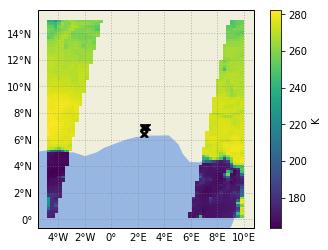

In [7]:
#3. POINTS OF INTEREST

# The following dataset satellite images of a certain region with specific settings (37GHz band, Horizontal Polarization, Ascending recording )
# ds = xr.open_dataset('C:\\Users\\908138\\githubdata\\37ghz_25km_H_A\\NSIDC-0630-EASE2_T25km-AQUA-AMSRE-36H-A_2010.nc')
ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
# get a mesh of the coordinates in grid's projection
xi, yi = np.meshgrid(ds.x, ds.y)

# the chosen projection is not (yet) supported by caropy.crs, so we need to do the transformation ourselves for now. 
# No biggy, here we go

# define the proj4string belonging to the grids you are downloading. You can find these in a downloaded sample 
# under the variable/attribute crs.proj4text. Here we simply copy-paste that.
proj4str = '+proj=cea +lat_0=0 +lon_0=0 +lat_ts=30 +x_0=0 +y_0=0 +ellps=WGS84 +datum=WGS84 +units=m'
# we define a projection object for the projection used in the downloaded grids.
proj_in = pyproj.Proj(proj4str)
# we define a projection object for lat-lon WGS84 (EPSG code 4326)
proj_out = pyproj.Proj(init='epsg:4326')

loni, lati = pyproj.transform(proj_in, proj_out, xi, yi)
# now drape the data on the map
p = ax.pcolormesh(loni, lati, ds['TB'][1].values, transform=ccrs.PlateCarree())

# Ouémé delta 3 point calibration method - this is the current method that I'm testing.
points_interest = [(2.4526, 6.4365),  #original (2.43, 6.43) #wet calibration - always covered in water (lake Nokoué)             
                   (2.69936, 6.90851), #(2.6386, 6.8748), #original (2.69936, 6.90851), #bonou dry calibration
                   (2.4334, 6.8748), #good results(2.4334, 6.8748) #original(2.44936, 6.90851) #bonou measurement cell
                  ## so far the final input
                   (2.42135, 6.4365), #wet
                   (2.39010, 6.4365), #wet
                   (2.48385, 6.4365), #wet
                   (2.51510, 6.4365), #wet
                   (2.4526, 6.46775), #wet
                   (2.4526, 6.40525), #wet
                   (2.48061, 6.90851), #dry
                   (2.51186, 6.90851), #dry
                   (2.54311, 6.90851), #dry
                   (2.57436, 6.90851), #dry
                   (2.60561, 6.90851), #dry
                   (2.63686, 6.90851), #dry
                   (2.66811, 6.90851), #dry
                   (2.69936, 6.90851), #dry
#                    (2.60561, 6.93976), #dry
#                    (2.60561, 6.97101), #dry
#                    (2.60561, 6.87726), #dry
#                    (2.60561, 6.84601), #dry
                   (2.44936, 6.90851), #measurement original
                   (2.41811, 6.93976), #measurement
                   (2.44936, 6.93976), #measurement
                   (2.41811, 6.90851), #measurement
                   (2.41811, 6.87726), #measurement
                   (2.44936, 6.87726)  #measurement
                  ]

# (2.43, 6.43),  #wet calibration - always covered in water (lake Nokoué)
# points_interest = [(2.43, 6.43),  #wet calibration - always covered in water (lake Nokoué)
                   
#                    (2.25, 6.57),  #dry calibration 1 - never affected by "fluvial" inundations
#                    (2.43, 6.55),  #measurement cell 1 - sometimes affected, real point of interest
                   
#                    (2.25, 6.82),  #dry calibration 2
#                    (2.43, 6.80),  #measurement cell 2
                   
#                    (2.25, 7.40),  #dry calibration 3 (7.07 normally)
#                    (2.43, 7.05),  #measurement cell 3
                   
#                    (2.25, 7.40),  #dry calibration 4 (7.32 normally)
#                    (2.43, 7.30),   #measurement cell 4
                   
#                    (2.69936, 6.90851), #bonou dry calibration
#                    (2.44936, 6.90851) #bonou measurement cell
#                   ]


# # Ouémé gaging station Hounkpe and Badou (2007)
# points_interest = [(2.4406387000000223, 6.893251099999999),
#                    (2.2999999999999545, 7.099999999999999),
#                    (2.4851462999999967, 8.0335995),
#                    (2.0499999999999545, 7.566667)
# ]

#Some coding to visualise the area. 
ax = plt.axes(projection=ccrs.PlateCarree())
ax = nsidc.plot_points(ax, points_interest, marker='x', color='k', linewidth=0., transform=ccrs.PlateCarree())
plt.colorbar(p, label='K')
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle=':')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

# Gracefully close ds
ds.close()

In [8]:
# ds_37ghz_25km_H_D

In [9]:
#4. COORDINATE SYSTEM PROJECTIONS
#Transforming the coordinate system. The data is available from a Measures dataset by NASA with a weird projection system
proj4str = '+proj=cea +lat_0=0 +lon_0=0 +lat_ts=30 +x_0=0 +y_0=0 +ellps=WGS84 +datum=WGS84 +units=m'

# we define a projection object for lat-lon WGS84 (EPSG code 4326)
proj_out = pyproj.Proj(init='epsg:4326')
# we define a projection object for the projection used in the downloaded grids.
proj_in = pyproj.Proj(proj4str)

# here we convert the coordinates in lat-lon into the coordinate system of the downloaded grids.
points_xy = nsidc.proj_coords(points_interest, proj_out, proj_in)


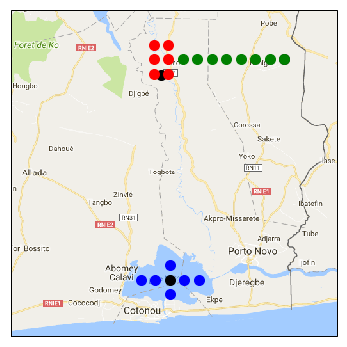

In [10]:
# 5.VISUALISE POINTS OF INTEREST
# first have a look at the points
osm_tiles = moa()
x, y = zip(*points_interest)

plt.figure(figsize=(6, 6))

# Use the tile's projection for the underlying map.
ax = plt.axes(projection=osm_tiles.crs)

# Add the tiles at zoom level 10.
ax.add_image(osm_tiles, 10)
# ax.plot(x, y, color='r', marker='.', markersize=20, linewidth=0., transform=ccrs.PlateCarree())
ax.plot(x[0:3], y[0:3], color='black', marker='.', markersize=20, linewidth=0., transform=ccrs.PlateCarree()) #original
ax.plot(x[3:9], y[3:9], color='b', marker='.', markersize=20, linewidth=0., transform=ccrs.PlateCarree()) #wet
ax.plot(x[9:17], y[9:17], color='g', marker='.', markersize=20, linewidth=0., transform=ccrs.PlateCarree()) #original
ax.plot(x[17:25], y[17:25], color='r', marker='.', markersize=20, linewidth=0., transform=ccrs.PlateCarree()) #measurement
# ax.plot(x[9:17], y[9:17], color='g', marker='.', markersize=20, linewidth=0., transform=ccrs.PlateCarree()) #chosen

plt.show()

In [11]:
# print(x[0:3])
# print(x[3:9])
# y

# Loading Brightness Temperature Data 2010

In [12]:
#6. LOAD AND MODIFY TB (BRIGHTNESS TEMPERATURE) TIMESERIES

points_x, points_y = zip(*points_xy)

# Loading the data in x-y coordinates
ts_37ghz_3km_H_D = ds_37ghz_3km_H_D.sel_points(x=list(points_x), y=list(points_y), method='nearest')
ts_37ghz_3km_H_A = ds_37ghz_3km_H_A.sel_points(x=list(points_x), y=list(points_y), method='nearest')
ts_37ghz_25km_H_A = ds_37ghz_25km_H_A.sel_points(x=list(points_x), y=list(points_y), method='nearest')
ts_37ghz_25km_H_D = ds_37ghz_25km_H_D.sel_points(x=list(points_x), y=list(points_y), method='nearest')
ts_37ghz_25km_V_A = ds_37ghz_25km_V_A.sel_points(x=list(points_x), y=list(points_y), method='nearest')
ts_37ghz_25km_V_D = ds_37ghz_25km_V_D.sel_points(x=list(points_x), y=list(points_y), method='nearest')
ts_89ghz_3km_H_A = ds_89ghz_3km_H_A.sel_points(x=list(points_x), y=list(points_y), method='nearest')

ts_89ghz_3km_V_A = ds_89ghz_3km_V_A.sel_points(x=list(points_x), y=list(points_y), method='nearest')

# Fill up the NaN entries in the raw data series with values to obtain daily consistency (and optionally plot):

#----------values_37ghz_25km_H_D----------------------------------------------------------------------------------
# for n in range(len(ts_37ghz_25km_H_A['TB'])):
values_37ghz_25km_H_D = ts_37ghz_25km_H_D['TB'].values
#     plt.plot(values_37ghz_25km_H_A[n], marker='.', label='point - 37GHz, H, A {:d}'.format(n + 1))

TB_37ghz_25km_H_D_wet= pd.DataFrame(values_37ghz_25km_H_D[0])
TB_37ghz_25km_H_D_wet.fillna(method='bfill',inplace=True)
TB_37ghz_25km_H_D_wet_ma = TB_37ghz_25km_H_D_wet.rolling(window=4,center=False).mean()
# TB_37ghz_25km_H_D_wet

TB_37ghz_25km_H_D_dry= pd.DataFrame(values_37ghz_25km_H_D[1])
TB_37ghz_25km_H_D_dry.fillna(method='bfill',inplace=True)
TB_37ghz_25km_H_D_dry_ma = TB_37ghz_25km_H_D_dry.rolling(window=4,center=False).mean()
# TB_37ghz_25km_H_D_dry

TB_37ghz_25km_H_D_measurement= pd.DataFrame(values_37ghz_25km_H_D[2])
TB_37ghz_25km_H_D_measurement.fillna(method='bfill',inplace=True)
TB_37ghz_25km_H_D_measurement_ma = TB_37ghz_25km_H_D_measurement.rolling(window=4,center=False).mean()
# TB_37ghz_25km_H_D_measurement

#----------values_37ghz_3km_H_D----------------------------------------------------------------------------------
# plt.figure(figsize=(14,6))
values_37ghz_3km_H_D = ts_37ghz_3km_H_D['TB'].values
# for n in range(len(ts_37ghz_25km_H_A['TB'])):
#     plt.plot(values_37ghz_25km_H_A[n], marker='.', label='point - 37GHz, H, A {:d}'.format(n + 1))
    
TB_37ghz_3km_H_D_wet= pd.DataFrame(values_37ghz_3km_H_D[0])
TB_37ghz_3km_H_D_wet.fillna(method='bfill',inplace=True)
TB_37ghz_3km_H_D_wet_ma = TB_37ghz_3km_H_D_wet.rolling(window=4,center=False).mean()
# TB_37ghz_25km_H_A_wet

TB_37ghz_3km_H_D_dry= pd.DataFrame(values_37ghz_3km_H_D[1])
TB_37ghz_3km_H_D_dry.fillna(method='bfill',inplace=True)
TB_37ghz_3km_H_D_dry_ma = TB_37ghz_3km_H_D_dry.rolling(window=4,center=False).mean()
# TB_37ghz_25km_H_A_dry

TB_37ghz_3km_H_D_measurement= pd.DataFrame(values_37ghz_3km_H_D[2])
TB_37ghz_3km_H_D_measurement.fillna(method='bfill',inplace=True)
TB_37ghz_3km_H_D_measurement_ma = TB_37ghz_3km_H_D_measurement.rolling(window=4,center=False).mean()
# TB_37ghz_25km_H_A_measurement


#----------values_37ghz_3km_H_A----------------------------------------------------------------------------------
# plt.figure(figsize=(14,6))
values_37ghz_3km_H_A = ts_37ghz_3km_H_A['TB'].values
# for n in range(len(ts_37ghz_25km_H_A['TB'])):
#     plt.plot(values_37ghz_25km_H_A[n], marker='.', label='point - 37GHz, H, A {:d}'.format(n + 1))
    
TB_37ghz_3km_H_A_wet= pd.DataFrame(values_37ghz_3km_H_A[0])
TB_37ghz_3km_H_A_wet.fillna(method='bfill',inplace=True)
TB_37ghz_3km_H_A_wet_ma = TB_37ghz_3km_H_A_wet.rolling(window=4,center=False).mean()
# TB_37ghz_25km_H_A_wet

TB_37ghz_3km_H_A_dry= pd.DataFrame(values_37ghz_3km_H_A[1])
TB_37ghz_3km_H_A_dry.fillna(method='bfill',inplace=True)
TB_37ghz_3km_H_A_dry_ma = TB_37ghz_3km_H_A_dry.rolling(window=4,center=False).mean()
# TB_37ghz_25km_H_A_dry

TB_37ghz_3km_H_A_measurement= pd.DataFrame(values_37ghz_3km_H_A[2])
TB_37ghz_3km_H_A_measurement.fillna(method='bfill',inplace=True)
TB_37ghz_3km_H_A_measurement_ma = TB_37ghz_3km_H_A_measurement.rolling(window=4,center=False).mean()
# TB_37ghz_25km_H_A_measurement


#----------values_37ghz_25km_H_A----------------------------------------------------------------------------------
# plt.figure(figsize=(14,6))
values_37ghz_25km_H_A = ts_37ghz_25km_H_A['TB'].values
# for n in range(len(ts_37ghz_25km_H_A['TB'])):
#     plt.plot(values_37ghz_25km_H_A[n], marker='.', label='point - 37GHz, H, A {:d}'.format(n + 1))
    
TB_37ghz_25km_H_A_wet= pd.DataFrame(values_37ghz_25km_H_A[0])
TB_37ghz_25km_H_A_wet.fillna(method='bfill',inplace=True)
TB_37ghz_25km_H_A_wet_ma = TB_37ghz_25km_H_A_wet.rolling(window=4,center=False).mean()
# TB_37ghz_25km_H_A_wet

TB_37ghz_25km_H_A_dry= pd.DataFrame(values_37ghz_25km_H_A[1])
TB_37ghz_25km_H_A_dry.fillna(method='bfill',inplace=True)
TB_37ghz_25km_H_A_dry_ma = TB_37ghz_25km_H_A_dry.rolling(window=4,center=False).mean()
# TB_37ghz_25km_H_A_dry

TB_37ghz_25km_H_A_measurement= pd.DataFrame(values_37ghz_25km_H_A[2])
TB_37ghz_25km_H_A_measurement.fillna(method='bfill',inplace=True)
TB_37ghz_25km_H_A_measurement_ma = TB_37ghz_25km_H_A_measurement.rolling(window=4,center=False).mean()
# TB_37ghz_25km_H_A_measurement


#----------values_37ghz_25km_V_A----------------------------------------------------------------------------------
# plt.figure(figsize=(14,6))
values_37ghz_25km_V_A = ts_37ghz_25km_V_A['TB'].values
# for n in range(len(ts_37ghz_25km_H_A['TB'])):
#     plt.plot(values_37ghz_25km_H_A[n], marker='.', label='point - 37GHz, H, A {:d}'.format(n + 1))
    
TB_37ghz_25km_V_A_wet= pd.DataFrame(values_37ghz_25km_V_A[0])
TB_37ghz_25km_V_A_wet.fillna(method='bfill',inplace=True)
TB_37ghz_25km_V_A_wet_ma = TB_37ghz_25km_V_A_wet.rolling(window=4,center=False).mean()
# TB_37ghz_25km_H_A_wet

TB_37ghz_25km_V_A_dry= pd.DataFrame(values_37ghz_25km_V_A[1])
TB_37ghz_25km_V_A_dry.fillna(method='bfill',inplace=True)
TB_37ghz_25km_V_A_dry_ma = TB_37ghz_25km_V_A_dry.rolling(window=4,center=False).mean()
# TB_37ghz_25km_H_A_dry

TB_37ghz_25km_V_A_measurement= pd.DataFrame(values_37ghz_25km_V_A[2])
TB_37ghz_25km_V_A_measurement.fillna(method='bfill',inplace=True)
TB_37ghz_25km_V_A_measurement_ma = TB_37ghz_25km_V_A_measurement.rolling(window=4,center=False).mean()
# TB_37ghz_25km_H_A_measurement


#----------values_37ghz_25km_V_D----------------------------------------------------------------------------------
# for n in range(len(ts_37ghz_25km_H_A['TB'])):
values_37ghz_25km_V_D = ts_37ghz_25km_V_D['TB'].values
#     plt.plot(values_37ghz_25km_H_A[n], marker='.', label='point - 37GHz, H, A {:d}'.format(n + 1))

TB_37ghz_25km_V_D_wet= pd.DataFrame(values_37ghz_25km_V_D[0])
TB_37ghz_25km_V_D_wet.fillna(method='bfill',inplace=True)
TB_37ghz_25km_V_D_wet_ma = TB_37ghz_25km_V_D_wet.rolling(window=4,center=False).mean()
# TB_37ghz_25km_H_D_wet

TB_37ghz_25km_V_D_dry= pd.DataFrame(values_37ghz_25km_V_D[1])
TB_37ghz_25km_V_D_dry.fillna(method='bfill',inplace=True)
TB_37ghz_25km_V_D_dry_ma = TB_37ghz_25km_V_D_dry.rolling(window=4,center=False).mean()
# TB_37ghz_25km_H_D_dry

TB_37ghz_25km_V_D_measurement= pd.DataFrame(values_37ghz_25km_V_D[2])
TB_37ghz_25km_V_D_measurement.fillna(method='bfill',inplace=True)
TB_37ghz_25km_V_D_measurement_ma = TB_37ghz_25km_V_D_measurement.rolling(window=4,center=False).mean()
# TB_37ghz_25km_H_D_measurement

#----------values_89ghz_3km_H_A----------------------------------------------------------------------------------
# plt.figure(figsize=(14,6))
values_89ghz_3km_H_A = ts_89ghz_3km_H_A['TB'].values
# for n in range(len(ts_37ghz_25km_H_A['TB'])):
#     plt.plot(values_37ghz_25km_H_A[n], marker='.', label='point - 37GHz, H, A {:d}'.format(n + 1))
    
TB_89ghz_3km_H_A_wet= pd.DataFrame(values_89ghz_3km_H_A[0])
TB_89ghz_3km_H_A_wet.fillna(method='bfill',inplace=True)
TB_89ghz_3km_H_A_wet_ma = TB_89ghz_3km_H_A_wet.rolling(window=4,center=False).mean()
# TB_37ghz_25km_H_A_wet

TB_89ghz_3km_H_A_dry= pd.DataFrame(values_89ghz_3km_H_A[1])
TB_89ghz_3km_H_A_dry.fillna(method='bfill',inplace=True)
TB_89ghz_3km_H_A_dry_ma = TB_89ghz_3km_H_A_dry.rolling(window=4,center=False).mean()
# TB_37ghz_25km_H_A_dry

TB_89ghz_3km_H_A_measurement= pd.DataFrame(values_89ghz_3km_H_A[2])
TB_89ghz_3km_H_A_measurement.fillna(method='bfill',inplace=True)
TB_89ghz_3km_H_A_measurement_ma = TB_89ghz_3km_H_A_measurement.rolling(window=4,center=False).mean()
# TB_37ghz_25km_H_A_measurement

print('done')

C:\ProgramData\Anaconda3\envs\benin_env\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Dataset.sel_points is deprecated: use Dataset.sel()instead.
  
C:\ProgramData\Anaconda3\envs\benin_env\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: Dataset.sel_points is deprecated: use Dataset.sel()instead.
  import sys
C:\ProgramData\Anaconda3\envs\benin_env\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: Dataset.sel_points is deprecated: use Dataset.sel()instead.
  
C:\ProgramData\Anaconda3\envs\benin_env\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Dataset.sel_points is deprecated: use Dataset.sel()instead.
  if __name__ == '__main__':
C:\ProgramData\Anaconda3\envs\benin_env\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: Dataset.sel_points is deprecated: use Dataset.sel()instead.
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\envs\benin_env\lib\site-packages\ipykernel_launcher.py:11

done


# WET CALIBRATION VS. DRY CALIBRATION VS. MEASUREMENT CELL

C:\ProgramData\Anaconda3\envs\benin_env\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


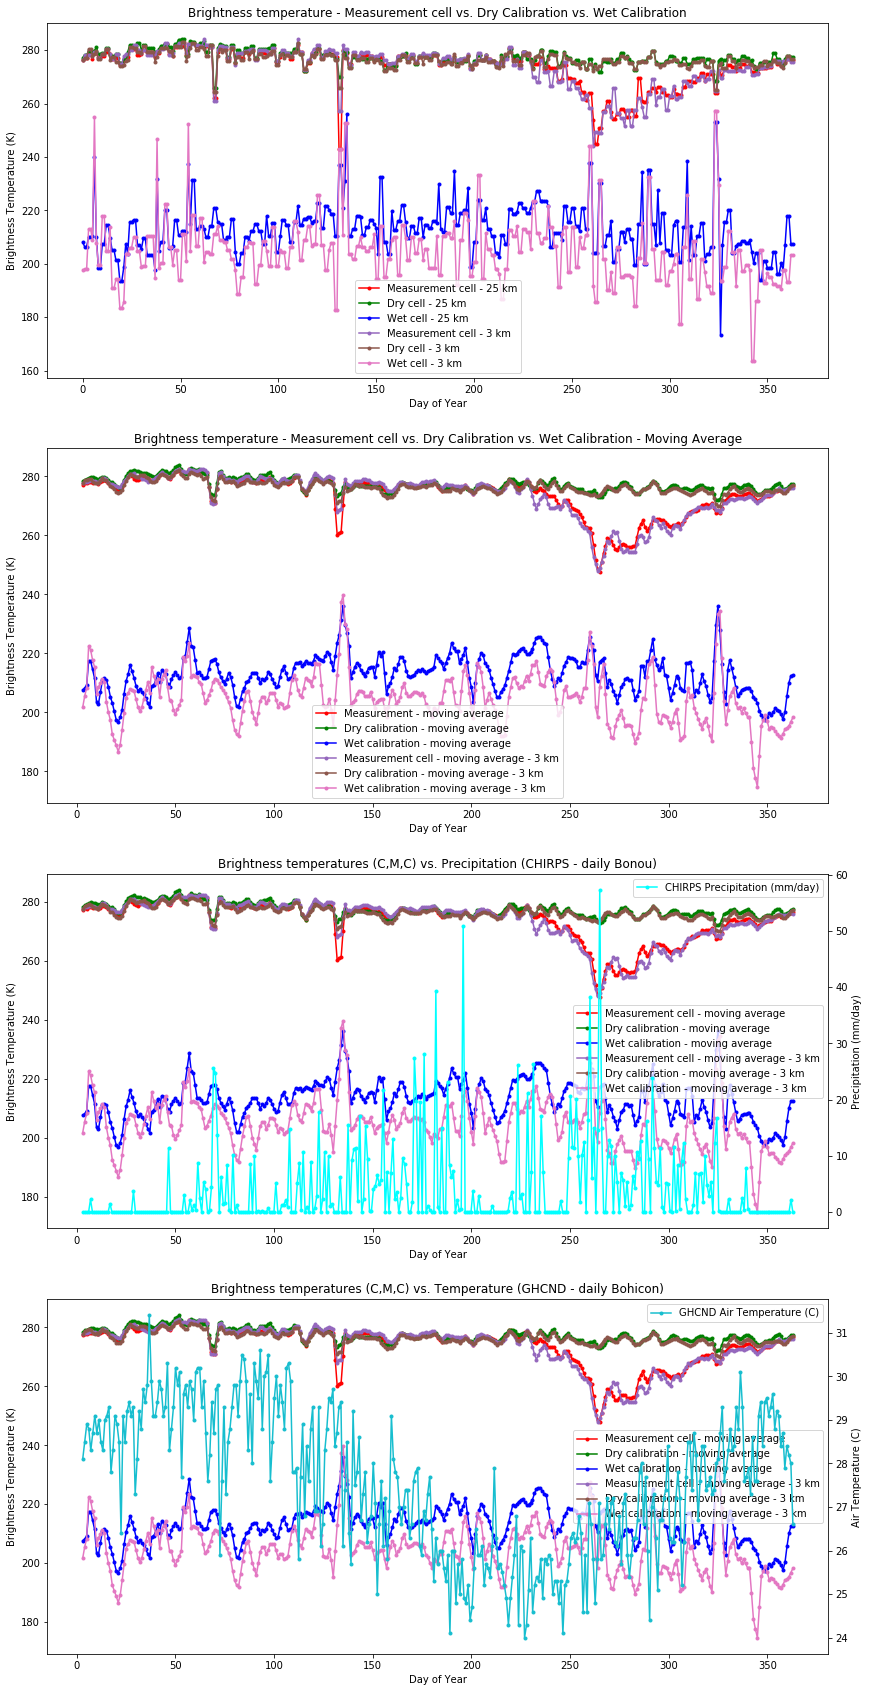

In [15]:
# PLOT WET CALIBRATION VS. DRY CALIBRATION VS. MEASUREMENT CELL

#----------ORIGINAL----------------------------------------------------------------------------------------
fig = plt.figure(figsize=(14,30))
# values_37ghz_25km_H_A = ts_37ghz_25km_H_A['TB'].values
# for n in range(1):
# for n in range(len(1)): #len(TB_37ghz_25km_H_A_measurement)
ax1 = fig.add_subplot(411) 
plt.title('Brightness temperature - Measurement cell vs. Dry Calibration vs. Wet Calibration')
plt.xlabel('Day of Year')
plt.ylabel('Brightness Temperature (K)')
# 25 km data
ax1.plot(TB_37ghz_25km_H_D_measurement, marker='.', color='red', label = 'Measurement cell - 25 km')
ax1.plot(TB_37ghz_25km_H_D_dry, marker='.', color='green', label = 'Dry cell - 25 km')
ax1.plot(TB_37ghz_25km_H_D_wet, marker='.', color='blue', label = 'Wet cell - 25 km')
# 3 km data
ax1.plot(TB_37ghz_3km_H_D_measurement, marker='.', color='C4', label = 'Measurement cell - 3 km')
ax1.plot(TB_37ghz_3km_H_D_dry, marker='.', color='C5', label = 'Dry cell - 3 km')
ax1.plot(TB_37ghz_3km_H_D_wet, marker='.', color='C6', label = 'Wet cell - 3 km')
plt.legend(loc='best')
 
    
#----------MOVING AVERAGE----------------------------------------------------------------------------------------
# plt.figure(figsize=(14,6))
# values_37ghz_25km_H_A = ts_37ghz_25km_H_A['TB'].values
ax2 = fig.add_subplot(412)
# 25 km data
ax2.plot(TB_37ghz_25km_H_D_measurement_ma, marker='.', color='red', label = 'Measurement - moving average')
ax2.plot(TB_37ghz_25km_H_D_dry_ma, marker='.', color='green', label = 'Dry calibration - moving average')
ax2.plot(TB_37ghz_25km_H_D_wet_ma, marker='.', color='blue', label = 'Wet calibration - moving average')
# 3 km data
ax2.plot(TB_37ghz_3km_H_D_measurement_ma, marker='.', color='C4', label = 'Measurement cell - moving average - 3 km')
ax2.plot(TB_37ghz_3km_H_D_dry_ma, marker='.', color='C5', label = 'Dry calibration - moving average - 3 km')
ax2.plot(TB_37ghz_3km_H_D_wet_ma, marker='.', color='C6', label = 'Wet calibration - moving average - 3 km')

plt.legend()
plt.title('Brightness temperature - Measurement cell vs. Dry Calibration vs. Wet Calibration - Moving Average')
plt.xlabel('Day of Year')
plt.ylabel('Brightness Temperature (K)') 

#----------MOVING AVERAGE + PRECIPITATION----------------------------------------------------------------------------------------
ax3 = fig.add_subplot(413)
# 25 km data
ax3.plot(TB_37ghz_25km_H_D_measurement_ma, marker='.', color='red', label = 'Measurement cell - moving average')
ax3.plot(TB_37ghz_25km_H_D_dry_ma, marker='.', color='green', label = 'Dry calibration - moving average')
ax3.plot(TB_37ghz_25km_H_D_wet_ma, marker='.', color='blue', label = 'Wet calibration - moving average')
# 3 km data
ax3.plot(TB_37ghz_3km_H_D_measurement_ma, marker='.', color='C4', label = 'Measurement cell - moving average - 3 km')
ax3.plot(TB_37ghz_3km_H_D_dry_ma, marker='.', color='C5', label = 'Dry calibration - moving average - 3 km')
ax3.plot(TB_37ghz_3km_H_D_wet_ma, marker='.', color='C6', label = 'Wet calibration - moving average - 3 km')

plt.title('Brightness temperatures (C,M,C) vs. Precipitation (CHIRPS - daily Bonou)')
plt.xlabel('Day of Year')
plt.ylabel('Brightness Temperature (K)') 

ax4 = fig.add_subplot(413)
plt.legend(loc=5)

ax4 = fig.add_subplot(413, frameon = False)
ax4.yaxis.tick_right()
ax4.yaxis.set_label_position("right")
ax4.xaxis.set_visible(False)
# ax4 = plt.axes()
# x_axis = ax4.axes.get_xaxis()
# x_axis.set_visible(False)
precipitation = ax4.plot(ds_p, marker='.', color = 'cyan', label = 'CHIRPS Precipitation (mm/day)')
plt.ylabel('Precipitation (mm/day)')
plt.legend(loc='best')

# ds_precipitation = ax3.plot(doy,q_2010, linestyle='-', color='C5',marker='.', label = 'Discharge')

#----------MOVING AVERAGE + TEMPERATURE----------------------------------------------------------------------------------------
ax5 = fig.add_subplot(414)
# 25 km data
ax5.plot(TB_37ghz_25km_H_D_measurement_ma, marker='.', color='red', label = 'Measurement cell - moving average')
ax5.plot(TB_37ghz_25km_H_D_dry_ma, marker='.', color='green', label = 'Dry calibration - moving average')
ax5.plot(TB_37ghz_25km_H_D_wet_ma, marker='.', color='blue', label = 'Wet calibration - moving average')
# 3 km data
ax5.plot(TB_37ghz_3km_H_D_measurement_ma, marker='.', color='C4', label = 'Measurement cell - moving average - 3 km')
ax5.plot(TB_37ghz_3km_H_D_dry_ma, marker='.', color='C5', label = 'Dry calibration - moving average - 3 km')
ax5.plot(TB_37ghz_3km_H_D_wet_ma, marker='.', color='C6', label = 'Wet calibration - moving average - 3 km')

plt.title('Brightness temperatures (C,M,C) vs. Temperature (GHCND - daily Bohicon)')
plt.xlabel('Day of Year')
plt.ylabel('Brightness Temperature (K)') 

# ax6 = fig.add_subplot(314)
plt.legend(loc=5)

ax6 = fig.add_subplot(414, frameon = False)
ax6.yaxis.tick_right()
ax6.yaxis.set_label_position("right")
ax6.xaxis.set_visible(False)
# ax4 = plt.axes()
# x_axis = ax4.axes.get_xaxis()
# x_axis.set_visible(False)
ax6.plot(temperature, marker='.', color = 'C9', label = 'GHCND Air Temperature (C)')
plt.ylabel('Air Temperature (C)')
plt.legend(loc='best')

#--------TESTING---------------------------------------------------------------------------------------



In [17]:
print('MAXIMA')
print('Max value 25 km Measurement cell:',TB_37ghz_25km_H_D_measurement[0].max(),'K')
print('Max value 3 km Measurement cell:',TB_37ghz_3km_H_D_measurement[0].max(),'K')

print('MEAN')
print('Max value 25 km Measurement cell:',TB_37ghz_25km_H_D_measurement[0].mean(),'K')
print('Max value 3 km Measurement cell:',TB_37ghz_3km_H_D_measurement[0].mean(),'K')

print('MINIMA')
print('Max value 25 km Measurement cell:',TB_37ghz_25km_H_D_measurement[0].min(),'K')
print('Max value 3 km Measurement cell:',TB_37ghz_3km_H_D_measurement[0].min(),'K')

MAXIMA
Max value 25 km Measurement cell: 282.72 K
Max value 3 km Measurement cell: 284.08 K
MEAN
Max value 25 km Measurement cell: 273.85626220703125 K
Max value 3 km Measurement cell: 273.8199462890625 K
MINIMA
Max value 25 km Measurement cell: 243.06999 K
Max value 3 km Measurement cell: 244.18 K


# LOCATION

C:\ProgramData\Anaconda3\envs\benin_env\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Dataset.sel_points is deprecated: use Dataset.sel()instead.
  
C:\ProgramData\Anaconda3\envs\benin_env\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Dataset.sel_points is deprecated: use Dataset.sel()instead.
  if __name__ == '__main__':


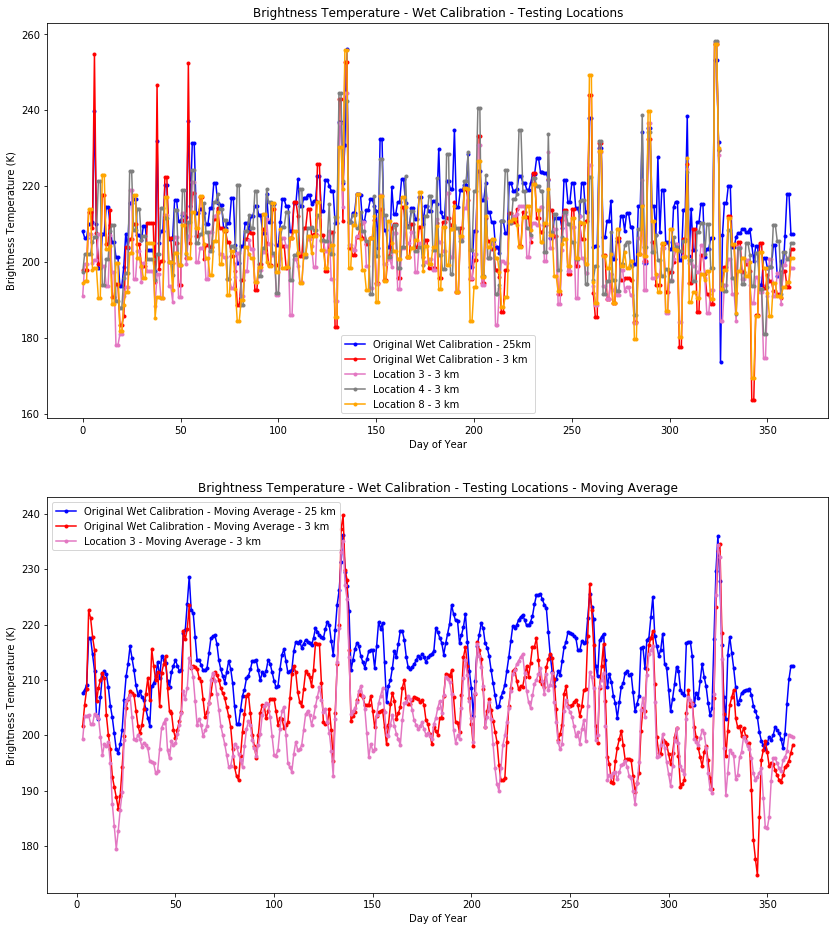

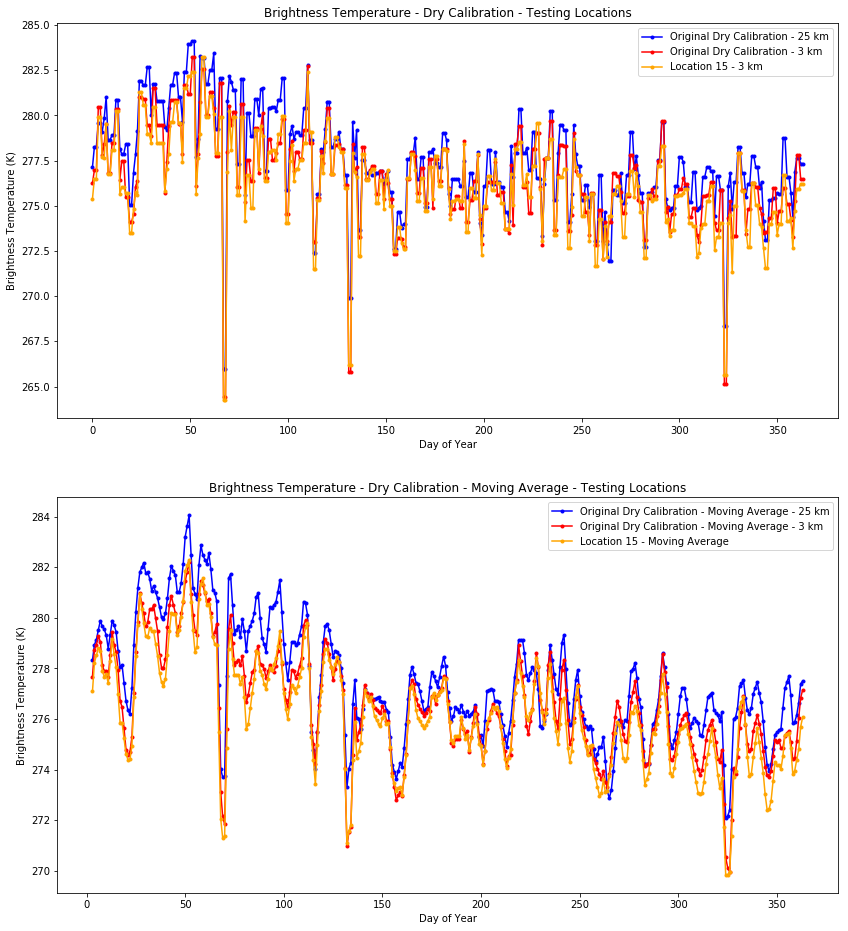

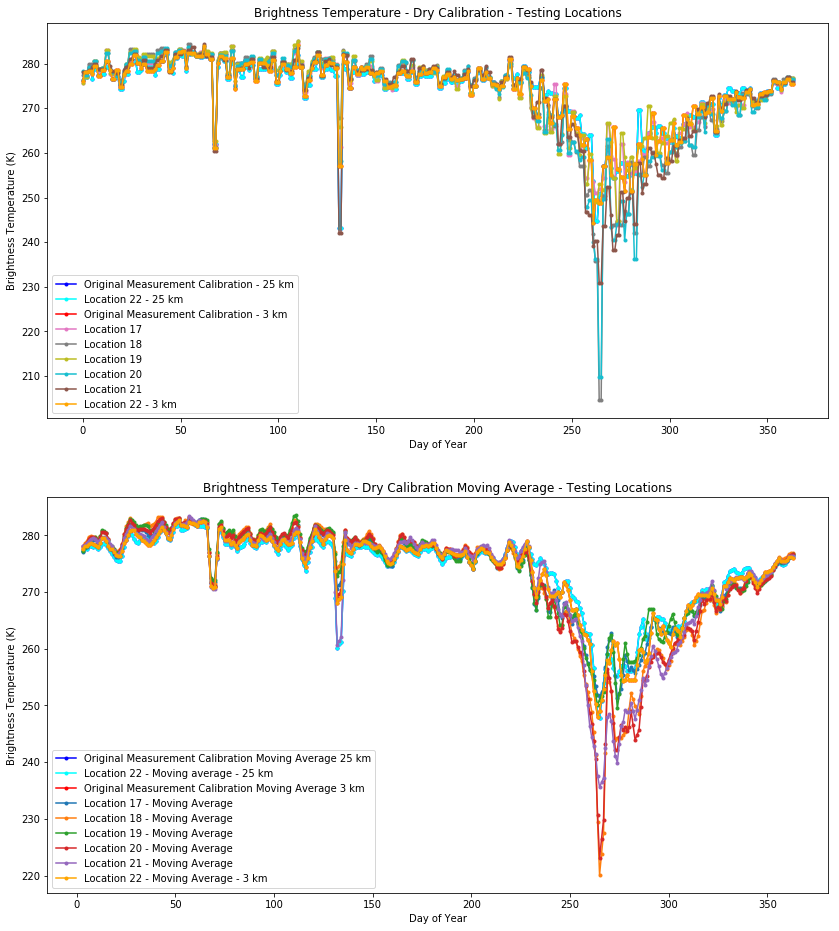

In [19]:
#6. LOAD AND MODIFY TB (BRIGHTNESS TEMPERATURE) TIMESERIES

points_x, points_y = zip(*points_xy)

# Loading the data in x-y coordinates
ts_37ghz_3km_H_D = ds_37ghz_3km_H_D.sel_points(x=list(points_x), y=list(points_y), method='nearest')
# ts_37ghz_3km_H_A = ds_37ghz_3km_H_A.sel_points(x=list(points_x), y=list(points_y), method='nearest')
# ts_37ghz_25km_H_A = ds_37ghz_25km_H_A.sel_points(x=list(points_x), y=list(points_y), method='nearest')
ts_37ghz_25km_H_D = ds_37ghz_25km_H_D.sel_points(x=list(points_x), y=list(points_y), method='nearest')
# ts_37ghz_25km_V_A = ds_37ghz_25km_V_A.sel_points(x=list(points_x), y=list(points_y), method='nearest')
# ts_37ghz_25km_V_D = ds_37ghz_25km_V_D.sel_points(x=list(points_x), y=list(points_y), method='nearest')
# ts_89ghz_3km_H_A = ds_89ghz_3km_H_A.sel_points(x=list(points_x), y=list(points_y), method='nearest')

#----------values_37ghz_25km_H_D----------------------------------------------------------------------------------
# for n in range(len(ts_37ghz_25km_H_A['TB'])):
values_37ghz_25km_H_D = ts_37ghz_25km_H_D['TB'].values
#     plt.plot(values_37ghz_25km_H_A[n], marker='.', label='point - 37GHz, H, A {:d}'.format(n + 1))

TB_37ghz_25km_H_D_wet= pd.DataFrame(values_37ghz_25km_H_D[0])
TB_37ghz_25km_H_D_wet.fillna(method='bfill',inplace=True)
TB_37ghz_25km_H_D_wet_ma = TB_37ghz_25km_H_D_wet.rolling(window=4,center=False).mean()
# TB_37ghz_25km_H_D_wet

TB_37ghz_25km_H_D_dry= pd.DataFrame(values_37ghz_25km_H_D[1])
TB_37ghz_25km_H_D_dry.fillna(method='bfill',inplace=True)
TB_37ghz_25km_H_D_dry_ma = TB_37ghz_25km_H_D_dry.rolling(window=4,center=False).mean()
# TB_37ghz_25km_H_D_dry

TB_37ghz_25km_H_D_measurement= pd.DataFrame(values_37ghz_25km_H_D[2])
TB_37ghz_25km_H_D_measurement.fillna(method='bfill',inplace=True)
TB_37ghz_25km_H_D_measurement_ma = TB_37ghz_25km_H_D_measurement.rolling(window=4,center=False).mean()
# TB_37ghz_25km_H_D_measurement

#----------WET LOCATION TESTING - 25 km----------------------------------------------------------------------------------
TB_37ghz_25km_H_D_wet_test3= pd.DataFrame(values_37ghz_25km_H_D[3])
TB_37ghz_25km_H_D_wet_test3.fillna(method='bfill',inplace=True)
TB_37ghz_25km_H_D_wet_ma_test3 = TB_37ghz_25km_H_D_wet_test3.rolling(window=4,center=False).mean()
# TB_37ghz_25km_H_D_wet_test#

TB_37ghz_25km_H_D_wet_test4= pd.DataFrame(values_37ghz_25km_H_D[4])
TB_37ghz_25km_H_D_wet_test4.fillna(method='bfill',inplace=True)
TB_37ghz_25km_H_D_wet_ma_test4 = TB_37ghz_25km_H_D_wet_test4.rolling(window=4,center=False).mean()
# TB_37ghz_25km_H_D_wet_test#

TB_37ghz_25km_H_D_wet_test5= pd.DataFrame(values_37ghz_25km_H_D[5])
TB_37ghz_25km_H_D_wet_test5.fillna(method='bfill',inplace=True)
TB_37ghz_25km_H_D_wet_ma_test5 = TB_37ghz_25km_H_D_wet_test5.rolling(window=4,center=False).mean()
# TB_37ghz_25km_H_D_wet_test#

TB_37ghz_25km_H_D_wet_test6= pd.DataFrame(values_37ghz_25km_H_D[6])
TB_37ghz_25km_H_D_wet_test6.fillna(method='bfill',inplace=True)
TB_37ghz_25km_H_D_wet_ma_test6 = TB_37ghz_25km_H_D_wet_test6.rolling(window=4,center=False).mean()
# TB_37ghz_25km_H_D_wet_test#

TB_37ghz_25km_H_D_wet_test7= pd.DataFrame(values_37ghz_25km_H_D[7])
TB_37ghz_25km_H_D_wet_test7.fillna(method='bfill',inplace=True)
TB_37ghz_25km_H_D_wet_ma_test7 = TB_37ghz_25km_H_D_wet_test7.rolling(window=4,center=False).mean()
# TB_37ghz_25km_H_D_wet_test#

TB_37ghz_25km_H_D_wet_test8= pd.DataFrame(values_37ghz_25km_H_D[8])
TB_37ghz_25km_H_D_wet_test8.fillna(method='bfill',inplace=True)
TB_37ghz_25km_H_D_wet_ma_test8 = TB_37ghz_25km_H_D_wet_test8.rolling(window=4,center=False).mean()
# TB_37ghz_25km_H_D_wet_test#

#----------values_37ghz_3km_H_D----------------------------------------------------------------------------------
# for n in range(len(ts_37ghz_25km_H_A['TB'])):
values_37ghz_3km_H_D = ts_37ghz_3km_H_D['TB'].values
#     plt.plot(values_37ghz_25km_H_A[n], marker='.', label='point - 37GHz, H, A {:d}'.format(n + 1))

TB_37ghz_3km_H_D_wet= pd.DataFrame(values_37ghz_3km_H_D[0])
TB_37ghz_3km_H_D_wet.fillna(method='bfill',inplace=True)
TB_37ghz_3km_H_D_wet_ma = TB_37ghz_3km_H_D_wet.rolling(window=4,center=False).mean()
# TB_37ghz_25km_H_D_wet

TB_37ghz_3km_H_D_dry= pd.DataFrame(values_37ghz_3km_H_D[1])
TB_37ghz_3km_H_D_dry.fillna(method='bfill',inplace=True)
TB_37ghz_3km_H_D_dry_ma = TB_37ghz_3km_H_D_dry.rolling(window=4,center=False).mean()
# TB_37ghz_25km_H_D_dry

TB_37ghz_3km_H_D_measurement= pd.DataFrame(values_37ghz_3km_H_D[2])
TB_37ghz_3km_H_D_measurement.fillna(method='bfill',inplace=True)
TB_37ghz_3km_H_D_measurement_ma = TB_37ghz_3km_H_D_measurement.rolling(window=4,center=False).mean()
# TB_37ghz_25km_H_D_measurement

#----------WET LOCATION TESTING - 3 km----------------------------------------------------------------------------------
TB_37ghz_3km_H_D_wet_test3= pd.DataFrame(values_37ghz_3km_H_D[3])
TB_37ghz_3km_H_D_wet_test3.fillna(method='bfill',inplace=True)
TB_37ghz_3km_H_D_wet_ma_test3 = TB_37ghz_3km_H_D_wet_test3.rolling(window=4,center=False).mean()
# TB_37ghz_25km_H_D_wet_test#

TB_37ghz_3km_H_D_wet_test4= pd.DataFrame(values_37ghz_3km_H_D[4])
TB_37ghz_3km_H_D_wet_test4.fillna(method='bfill',inplace=True)
TB_37ghz_3km_H_D_wet_ma_test4 = TB_37ghz_3km_H_D_wet_test4.rolling(window=4,center=False).mean()
# TB_37ghz_25km_H_D_wet_test#

TB_37ghz_3km_H_D_wet_test5= pd.DataFrame(values_37ghz_3km_H_D[5])
TB_37ghz_3km_H_D_wet_test5.fillna(method='bfill',inplace=True)
TB_37ghz_3km_H_D_wet_ma_test5 = TB_37ghz_3km_H_D_wet_test5.rolling(window=4,center=False).mean()
# TB_37ghz_25km_H_D_wet_test#

TB_37ghz_3km_H_D_wet_test6= pd.DataFrame(values_37ghz_3km_H_D[6])
TB_37ghz_3km_H_D_wet_test6.fillna(method='bfill',inplace=True)
TB_37ghz_3km_H_D_wet_ma_test6 = TB_37ghz_3km_H_D_wet_test6.rolling(window=4,center=False).mean()
# TB_37ghz_25km_H_D_wet_test#

TB_37ghz_3km_H_D_wet_test7= pd.DataFrame(values_37ghz_3km_H_D[7])
TB_37ghz_3km_H_D_wet_test7.fillna(method='bfill',inplace=True)
TB_37ghz_3km_H_D_wet_ma_test7 = TB_37ghz_3km_H_D_wet_test7.rolling(window=4,center=False).mean()
# TB_37ghz_25km_H_D_wet_test#

TB_37ghz_3km_H_D_wet_test8= pd.DataFrame(values_37ghz_3km_H_D[8])
TB_37ghz_3km_H_D_wet_test8.fillna(method='bfill',inplace=True)
TB_37ghz_3km_H_D_wet_ma_test8 = TB_37ghz_3km_H_D_wet_test8.rolling(window=4,center=False).mean()
# TB_37ghz_25km_H_D_wet_test#

#Plot wet location tests
fig = plt.figure(figsize=(14,16))
# values_37ghz_25km_H_A = ts_37ghz_25km_H_A['TB'].values
# for n in range(1):
# for n in range(len(1)): #len(TB_37ghz_25km_H_A_measurement)
ax1 = fig.add_subplot(211) 
plt.title('Brightness Temperature - Wet Calibration - Testing Locations')
plt.xlabel('Day of Year')
plt.ylabel('Brightness Temperature (K)')
# 25 km data
ax1.plot(TB_37ghz_25km_H_D_wet, marker='.', color='blue', label = 'Original Wet Calibration - 25km')
# ax1.plot(TB_37ghz_25km_H_D_wet_test8, marker='.', color='cyan', label = 'Location 8 - 25 km')

# 3 km data
ax1.plot(TB_37ghz_3km_H_D_wet, marker='.', color='red', label = 'Original Wet Calibration - 3 km')
ax1.plot(TB_37ghz_3km_H_D_wet_test3, marker='.', color='C6', label = 'Location 3 - 3 km')
ax1.plot(TB_37ghz_3km_H_D_wet_test4, marker='.', color='C7', label = 'Location 4 - 3 km')
# ax1.plot(TB_37ghz_3km_H_D_wet_test5, marker='.', color='C8', label = 'Location 5 - 3 km')
# ax1.plot(TB_37ghz_3km_H_D_wet_test6, marker='.', color='C9', label = 'Location 6 - 3 km')
# ax1.plot(TB_37ghz_3km_H_D_wet_test7, marker='.', color='C5', label = 'Location 7 - 3 km')
ax1.plot(TB_37ghz_3km_H_D_wet_test8, marker='.', color='orange', label = 'Location 8 - 3 km')
plt.legend(loc='best')

# #Variance of signal
# var_TB_37ghz_25km_H_D_wet = TB_37ghz_25km_H_D_wet[0].var()
# print('Variance of TB_37ghz_25km_H_D_wet is:', var_TB_37ghz_25km_H_D_wet)


#MOVING AVERAGE
ax2 = fig.add_subplot(212)
plt.title('Brightness Temperature - Wet Calibration - Testing Locations - Moving Average')
plt.xlabel('Day of Year')
plt.ylabel('Brightness Temperature (K)')
ax2.plot(TB_37ghz_25km_H_D_wet_ma, marker='.', color='blue', label = 'Original Wet Calibration - Moving Average - 25 km')
# ax2.plot(TB_37ghz_25km_H_D_wet_ma_test8, marker='.', color='cyan', label = 'Location 8 - Moving Average - 25 km')

ax2.plot(TB_37ghz_3km_H_D_wet_ma, marker='.', color='red', label = 'Original Wet Calibration - Moving Average - 3 km')
ax2.plot(TB_37ghz_3km_H_D_wet_ma_test3, marker='.', color='C6', label = 'Location 3 - Moving Average - 3 km')
# ax2.plot(TB_37ghz_3km_H_D_wet_ma_test4, marker='.', color='C7', label = 'Location 4 - Moving Average - 3 km')
# ax2.plot(TB_37ghz_3km_H_D_wet_ma_test5, marker='.', color='C8', label = 'Location 5 - Moving Average - 3 km')
# ax2.plot(TB_37ghz_3km_H_D_wet_ma_test6, marker='.', color='C9', label = 'Location 6 - Moving Average - 3 km')
# ax2.plot(TB_37ghz_3km_H_D_wet_ma_test7, marker='.', color='C5', label = 'Location 7 - Moving Average - 3 km')
# ax2.plot(TB_37ghz_3km_H_D_wet_ma_test8, marker='.', color='orange', label = 'Location 8 - Moving Average - 3 km')
plt.legend(loc='best')



#----------DRY LOCATION TESTING - 25 km----------------------------------------------------------------------------------

TB_37ghz_25km_H_D_dry_test16= pd.DataFrame(values_37ghz_25km_H_D[16])
TB_37ghz_25km_H_D_dry_test16.fillna(method='bfill',inplace=True)
TB_37ghz_25km_H_D_dry_ma_test16 = TB_37ghz_25km_H_D_dry_test16.rolling(window=4,center=False).mean()
# TB_37ghz_25km_H_D_wet_test#

#----------DRY LOCATION TESTING - 3km----------------------------------------------------------------------------------
TB_37ghz_3km_H_D_dry_test9= pd.DataFrame(values_37ghz_3km_H_D[9])
TB_37ghz_3km_H_D_dry_test9.fillna(method='bfill',inplace=True)
TB_37ghz_3km_H_D_dry_ma_test9 = TB_37ghz_3km_H_D_dry_test9.rolling(window=4,center=False).mean()
# TB_37ghz_25km_H_D_wet_test#

TB_37ghz_3km_H_D_dry_test10= pd.DataFrame(values_37ghz_3km_H_D[10])
TB_37ghz_3km_H_D_dry_test10.fillna(method='bfill',inplace=True)
TB_37ghz_3km_H_D_dry_ma_test10 = TB_37ghz_3km_H_D_dry_test10.rolling(window=4,center=False).mean()
# TB_37ghz_25km_H_D_wet_test#

TB_37ghz_3km_H_D_dry_test11= pd.DataFrame(values_37ghz_3km_H_D[11])
TB_37ghz_3km_H_D_dry_test11.fillna(method='bfill',inplace=True)
TB_37ghz_3km_H_D_dry_ma_test11 = TB_37ghz_3km_H_D_dry_test11.rolling(window=4,center=False).mean()
# TB_37ghz_25km_H_D_wet_test#

TB_37ghz_3km_H_D_dry_test12= pd.DataFrame(values_37ghz_3km_H_D[12])
TB_37ghz_3km_H_D_dry_test12.fillna(method='bfill',inplace=True)
TB_37ghz_3km_H_D_dry_ma_test12 = TB_37ghz_3km_H_D_dry_test12.rolling(window=4,center=False).mean()
# TB_37ghz_25km_H_D_wet_test#

TB_37ghz_3km_H_D_dry_test13= pd.DataFrame(values_37ghz_3km_H_D[13])
TB_37ghz_3km_H_D_dry_test13.fillna(method='bfill',inplace=True)
TB_37ghz_3km_H_D_dry_ma_test13 = TB_37ghz_3km_H_D_dry_test13.rolling(window=4,center=False).mean()
# TB_37ghz_25km_H_D_wet_test#

TB_37ghz_3km_H_D_dry_test14= pd.DataFrame(values_37ghz_3km_H_D[14])
TB_37ghz_3km_H_D_dry_test14.fillna(method='bfill',inplace=True)
TB_37ghz_3km_H_D_dry_ma_test14 = TB_37ghz_3km_H_D_dry_test14.rolling(window=4,center=False).mean()
# TB_37ghz_25km_H_D_wet_test#

TB_37ghz_3km_H_D_dry_test15= pd.DataFrame(values_37ghz_3km_H_D[15])
TB_37ghz_3km_H_D_dry_test15.fillna(method='bfill',inplace=True)
TB_37ghz_3km_H_D_dry_ma_test15 = TB_37ghz_3km_H_D_dry_test15.rolling(window=4,center=False).mean()
# TB_37ghz_25km_H_D_wet_test#

TB_37ghz_3km_H_D_dry_test16= pd.DataFrame(values_37ghz_3km_H_D[16])
TB_37ghz_3km_H_D_dry_test16.fillna(method='bfill',inplace=True)
TB_37ghz_3km_H_D_dry_ma_test16 = TB_37ghz_3km_H_D_dry_test16.rolling(window=4,center=False).mean()
# TB_37ghz_25km_H_D_wet_test#

#Plot dry location tests
fig = plt.figure(figsize=(14,16))
# values_37ghz_25km_H_A = ts_37ghz_25km_H_A['TB'].values
# for n in range(1):
# for n in range(len(1)): #len(TB_37ghz_25km_H_A_measurement)
ax1 = fig.add_subplot(211) 
plt.title('Brightness Temperature - Dry Calibration - Testing Locations')
plt.xlabel('Day of Year')
plt.ylabel('Brightness Temperature (K)')
# 25 km data
ax1.plot(TB_37ghz_25km_H_D_dry, marker='.', color='blue', label = 'Original Dry Calibration - 25 km')
# ax1.plot(TB_37ghz_25km_H_D_dry_test9, marker='.', color='cyan', label = 'Location 9 - 25 km')
# 3 km data
ax1.plot(TB_37ghz_3km_H_D_dry, marker='.', color='red', label = 'Original Dry Calibration - 3 km')
# ax1.plot(TB_37ghz_3km_H_D_dry_test9, marker='.', color='C0', label = 'Location 9 - 3km')
# ax1.plot(TB_37ghz_3km_H_D_dry_test10, marker='.', color='C1', label = 'Location 10 - 3 km')
# ax1.plot(TB_37ghz_3km_H_D_dry_test11, marker='.', color='C2', label = 'Location 11 - 3 km')
# ax1.plot(TB_37ghz_3km_H_D_dry_test12, marker='.', color='C3', label = 'Location 12 - 3 km')
# ax1.plot(TB_37ghz_3km_H_D_dry_test13, marker='.', color='C4', label = 'Location 13 - 3 km')
# ax1.plot(TB_37ghz_3km_H_D_dry_test14, marker='.', color='C5', label = 'Location 14 - 3 km')
ax1.plot(TB_37ghz_3km_H_D_dry_test15, marker='.', color='orange', label = 'Location 15 - 3 km')
# ax1.plot(TB_37ghz_3km_H_D_dry_test16, marker='.', color='orange', label = 'Location 16 - 3 km')
plt.legend(loc='best')

ax2 = fig.add_subplot(212)
plt.title('Brightness Temperature - Dry Calibration - Moving Average - Testing Locations')
plt.xlabel('Day of Year')
plt.ylabel('Brightness Temperature (K)')
#25 km data
ax2.plot(TB_37ghz_25km_H_D_dry_ma, marker='.', color='blue', label = 'Original Dry Calibration - Moving Average - 25 km')
# ax2.plot(TB_37ghz_25km_H_D_dry_ma_test9, marker='.', color='cyan', label = 'Location 9 - Moving Average - 25 km')
# 3 km data
ax2.plot(TB_37ghz_3km_H_D_dry_ma, marker='.', color='red', label = 'Original Dry Calibration - Moving Average - 3 km')
# ax2.plot(TB_37ghz_3km_H_D_dry_ma_test9, marker='.', color='C0', label = 'Location 9 - Moving Average')
# ax2.plot(TB_37ghz_3km_H_D_dry_ma_test10, marker='.', color='C1', label = 'Location 10 - Moving Average')
# ax2.plot(TB_37ghz_3km_H_D_dry_ma_test11, marker='.', color='C2', label = 'Location 11 - Moving Average')
# ax2.plot(TB_37ghz_3km_H_D_dry_ma_test12, marker='.', color='C3', label = 'Location 12 - Moving Average')
# ax2.plot(TB_37ghz_3km_H_D_dry_ma_test13, marker='.', color='C4', label = 'Location 13 - Moving Average')
# ax2.plot(TB_37ghz_3km_H_D_dry_ma_test14, marker='.', color='C5', label = 'Location 14 - Moving Average')
ax2.plot(TB_37ghz_3km_H_D_dry_ma_test15, marker='.', color='orange', label = 'Location 15 - Moving Average')
# ax2.plot(TB_37ghz_3km_H_D_dry_ma_test16, marker='.', color='orange', label = 'Location 16 - Moving Average - 3 km')
plt.legend(loc='best')

#----------MEASUREMENT LOCATION TESTING - 25 km----------------------------------------------------------------------------------
TB_37ghz_25km_H_D_measurement_test17= pd.DataFrame(values_37ghz_25km_H_D[17])
TB_37ghz_25km_H_D_measurement_test17.fillna(method='bfill',inplace=True)
TB_37ghz_25km_H_D_measurement_ma_test17 = TB_37ghz_25km_H_D_measurement_test17.rolling(window=4,center=False).mean()
# TB_37ghz_25km_H_D_wet_test#

TB_37ghz_25km_H_D_measurement_test22= pd.DataFrame(values_37ghz_25km_H_D[22])
TB_37ghz_25km_H_D_measurement_test22.fillna(method='bfill',inplace=True)
TB_37ghz_25km_H_D_measurement_ma_test22 = TB_37ghz_25km_H_D_measurement_test22.rolling(window=4,center=False).mean()
# TB_37ghz_25km_H_D_wet_test#

#----------MEASUREMENT LOCATION TESTING - 3 km----------------------------------------------------------------------------------
TB_37ghz_3km_H_D_measurement_test17= pd.DataFrame(values_37ghz_3km_H_D[17])
TB_37ghz_3km_H_D_measurement_test17.fillna(method='bfill',inplace=True)
TB_37ghz_3km_H_D_measurement_ma_test17 = TB_37ghz_3km_H_D_measurement_test17.rolling(window=4,center=False).mean()
# TB_37ghz_25km_H_D_wet_test#

TB_37ghz_3km_H_D_measurement_test18= pd.DataFrame(values_37ghz_3km_H_D[18])
TB_37ghz_3km_H_D_measurement_test18.fillna(method='bfill',inplace=True)
TB_37ghz_3km_H_D_measurement_ma_test18 = TB_37ghz_3km_H_D_measurement_test18.rolling(window=4,center=False).mean()
# TB_37ghz_25km_H_D_wet_test#

TB_37ghz_3km_H_D_measurement_test19= pd.DataFrame(values_37ghz_3km_H_D[19])
TB_37ghz_3km_H_D_measurement_test19.fillna(method='bfill',inplace=True)
TB_37ghz_3km_H_D_measurement_ma_test19 = TB_37ghz_3km_H_D_measurement_test19.rolling(window=4,center=False).mean()
# TB_37ghz_25km_H_D_wet_test#

TB_37ghz_3km_H_D_measurement_test20= pd.DataFrame(values_37ghz_3km_H_D[20])
TB_37ghz_3km_H_D_measurement_test20.fillna(method='bfill',inplace=True)
TB_37ghz_3km_H_D_measurement_ma_test20 = TB_37ghz_3km_H_D_measurement_test20.rolling(window=4,center=False).mean()
# TB_37ghz_25km_H_D_wet_test#

TB_37ghz_3km_H_D_measurement_test21= pd.DataFrame(values_37ghz_3km_H_D[21])
TB_37ghz_3km_H_D_measurement_test21.fillna(method='bfill',inplace=True)
TB_37ghz_3km_H_D_measurement_ma_test21 = TB_37ghz_3km_H_D_measurement_test21.rolling(window=4,center=False).mean()
# TB_37ghz_25km_H_D_wet_test#

TB_37ghz_3km_H_D_measurement_test22= pd.DataFrame(values_37ghz_3km_H_D[22])
TB_37ghz_3km_H_D_measurement_test22.fillna(method='bfill',inplace=True)
TB_37ghz_3km_H_D_measurement_ma_test22 = TB_37ghz_3km_H_D_measurement_test22.rolling(window=4,center=False).mean()
# TB_37ghz_25km_H_D_wet_test#

#Plot dry location tests
fig = plt.figure(figsize=(14,16))
# values_37ghz_25km_H_A = ts_37ghz_25km_H_A['TB'].values
# for n in range(1):
# for n in range(len(1)): #len(TB_37ghz_25km_H_A_measurement)
ax1 = fig.add_subplot(211) 
plt.title('Brightness Temperature - Dry Calibration - Testing Locations')
plt.xlabel('Day of Year')
plt.ylabel('Brightness Temperature (K)')
# 25 km data
ax1.plot(TB_37ghz_25km_H_D_measurement, marker='.', color='blue', label = 'Original Measurement Calibration - 25 km')
ax1.plot(TB_37ghz_25km_H_D_measurement_test22, marker='.', color='cyan', label = 'Location 22 - 25 km')
ax1.plot(TB_37ghz_3km_H_D_measurement, marker='.', color='red', label = 'Original Measurement Calibration - 3 km')
ax1.plot(TB_37ghz_3km_H_D_measurement_test17, marker='.', color='C6', label = 'Location 17')
ax1.plot(TB_37ghz_3km_H_D_measurement_test18, marker='.', color='C7', label = 'Location 18')
ax1.plot(TB_37ghz_3km_H_D_measurement_test19, marker='.', color='C8', label = 'Location 19')
ax1.plot(TB_37ghz_3km_H_D_measurement_test20, marker='.', color='C9', label = 'Location 20')
ax1.plot(TB_37ghz_3km_H_D_measurement_test21, marker='.', color='C5', label = 'Location 21')
ax1.plot(TB_37ghz_3km_H_D_measurement_test22, marker='.', color='orange', label = 'Location 22 - 3 km')
plt.legend(loc='best')

ax2 = fig.add_subplot(212)
plt.title('Brightness Temperature - Dry Calibration Moving Average - Testing Locations')
plt.xlabel('Day of Year')
plt.ylabel('Brightness Temperature (K)')
ax2.plot(TB_37ghz_25km_H_D_measurement_ma, marker='.', color='blue', label = 'Original Measurement Calibration Moving Average 25 km')
ax2.plot(TB_37ghz_25km_H_D_measurement_ma_test22, marker='.', color='cyan', label = 'Location 22 - Moving average - 25 km')
ax2.plot(TB_37ghz_3km_H_D_measurement_ma, marker='.', color='red', label = 'Original Measurement Calibration Moving Average 3 km')
ax2.plot(TB_37ghz_3km_H_D_measurement_ma_test17, marker='.', color='C0', label = 'Location 17 - Moving Average')
ax2.plot(TB_37ghz_3km_H_D_measurement_ma_test18, marker='.', color='C1', label = 'Location 18 - Moving Average')
ax2.plot(TB_37ghz_3km_H_D_measurement_ma_test19, marker='.', color='C2', label = 'Location 19 - Moving Average')
ax2.plot(TB_37ghz_3km_H_D_measurement_ma_test20, marker='.', color='C3', label = 'Location 20 - Moving Average')
ax2.plot(TB_37ghz_3km_H_D_measurement_ma_test21, marker='.', color='C4', label = 'Location 21 - Moving Average')
ax2.plot(TB_37ghz_3km_H_D_measurement_ma_test22, marker='.', color='orange', label = 'Location 22 - Moving Average - 3 km')
plt.legend(loc='best')

In [21]:
# ax1.plot(TB_37ghz_25km_H_D_wet, marker='.', color='blue', label = 'Original Wet Calibration')
# ax1.plot(TB_37ghz_25km_H_D_wet_test3, marker='.', color='C0', label = 'Location 3')
# TB_37ghz_25km_H_D_wet_test8

# ASCENDING VS. DESCENDING NODE

Text(0,0.5,'Brightness Temperature (K)')

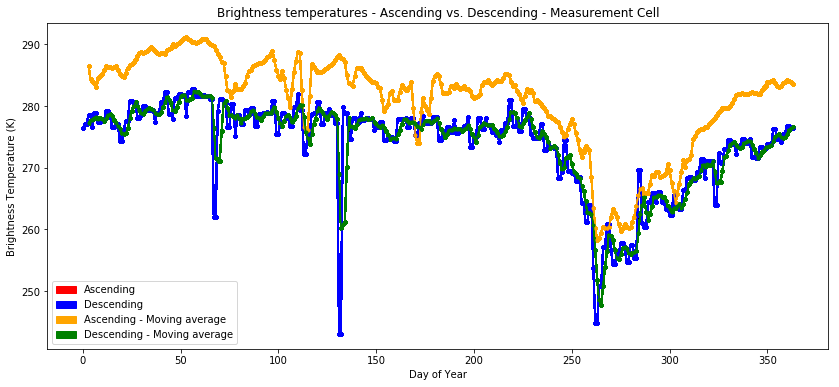

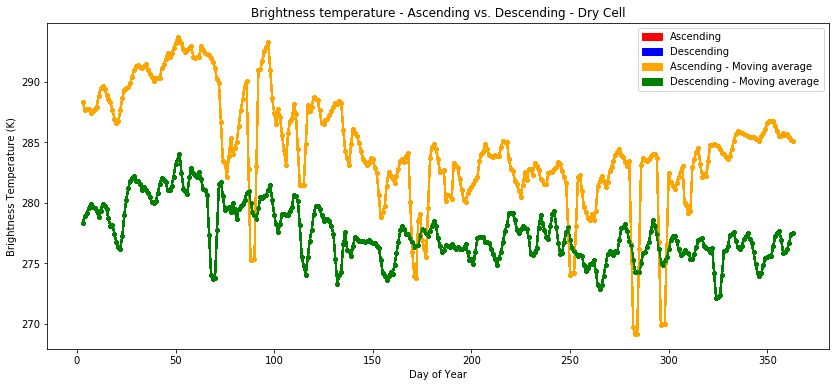

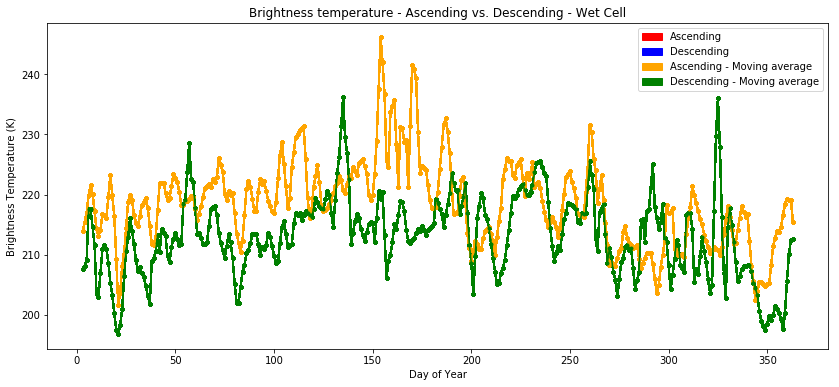

In [22]:
# PLOT ASCENDING VS. DESCENDING
# Ascending node: 1:30 PM LT overpass, South to North #https://nsidc.org/data/modis/terra_aqua_differences
# Descending node: 1:30 AM LT overpass, North to South

from sklearn.metrics import mean_squared_error

#----------MEASUREMENT CELL----------------------------------------------------------------------------------------
plt.figure(figsize=(14,6))
# values_37ghz_25km_H_A = ts_37ghz_25km_H_A['TB'].values
for n in range(len(TB_37ghz_25km_H_A_measurement)):
#     plt.plot(TB_37ghz_25km_H_A_measurement, marker='.', color='red')#, label='37GHz, Ascending, Measurement cell'
    plt.plot(TB_37ghz_25km_H_D_measurement, marker='.', color='blue')
    plt.plot(TB_37ghz_25km_H_A_measurement_ma, marker='.', color='orange')
    plt.plot(TB_37ghz_25km_H_D_measurement_ma, marker='.', color='green')
    
red_patch = mpatches.Patch(color='red', label='Ascending')
blue_patch = mpatches.Patch(color='blue', label='Descending')
orange_patch = mpatches.Patch(color='orange', label='Ascending - Moving average')
green_patch = mpatches.Patch(color='green', label='Descending - Moving average')

plt.legend(handles=[red_patch,blue_patch,orange_patch,green_patch])
plt.title('Brightness temperatures - Ascending vs. Descending - Measurement Cell')
plt.xlabel('Day of Year')
plt.ylabel('Brightness Temperature (K)')

# rms = np.sqrt(mean_squared_error(TB_37ghz_25km_H_A_measurement, TB_37ghz_25km_H_D_measurement))
# print(rms)


#----------DRY CALIBRATION----------------------------------------------------------------------------------------
plt.figure(figsize=(14,6))
# values_37ghz_25km_H_A = ts_37ghz_25km_H_A['TB'].values
for n in range(len(TB_37ghz_25km_H_A_measurement)):
#     plt.plot(TB_37ghz_25km_H_A_dry, marker='.', color='red')#, label='37GHz, Ascending, Measurement cell'
#     plt.plot(TB_37ghz_25km_H_D_dry, marker='.', color='blue')
    plt.plot(TB_37ghz_25km_H_A_dry_ma, marker='.', color='orange')
    plt.plot(TB_37ghz_25km_H_D_dry_ma, marker='.', color='green')

red_patch = mpatches.Patch(color='red', label='Ascending')
blue_patch = mpatches.Patch(color='blue', label='Descending')
orange_patch = mpatches.Patch(color='orange', label='Ascending - Moving average')
green_patch = mpatches.Patch(color='green', label='Descending - Moving average')

plt.legend(handles=[red_patch,blue_patch,orange_patch,green_patch])
plt.title('Brightness temperature - Ascending vs. Descending - Dry Cell')
plt.xlabel('Day of Year')
plt.ylabel('Brightness Temperature (K)')




#----------WET CALIBRATION----------------------------------------------------------------------------------------
plt.figure(figsize=(14,6))
# values_37ghz_25km_H_A = ts_37ghz_25km_H_A['TB'].values
for n in range(len(TB_37ghz_25km_H_A_measurement)):
#     plt.plot(TB_37ghz_25km_H_A_wet, marker='.', color='red')#, label='37GHz, Ascending, Measurement cell'
#     plt.plot(TB_37ghz_25km_H_D_wet, marker='.', color='blue')
    plt.plot(TB_37ghz_25km_H_A_wet_ma, marker='.', color='orange')
    plt.plot(TB_37ghz_25km_H_D_wet_ma, marker='.', color='green')

red_patch = mpatches.Patch(color='red', label='Ascending')
blue_patch = mpatches.Patch(color='blue', label='Descending')
orange_patch = mpatches.Patch(color='orange', label='Ascending - Moving average')
green_patch = mpatches.Patch(color='green', label='Descending - Moving average')

plt.legend(handles=[red_patch,blue_patch,orange_patch,green_patch])
plt.title('Brightness temperature - Ascending vs. Descending - Wet Cell')
plt.xlabel('Day of Year')
plt.ylabel('Brightness Temperature (K)')

# HORIZONTAL VS. VERTICAL POLARIZATION

Text(0,0.5,'Brightness Temperature (K)')

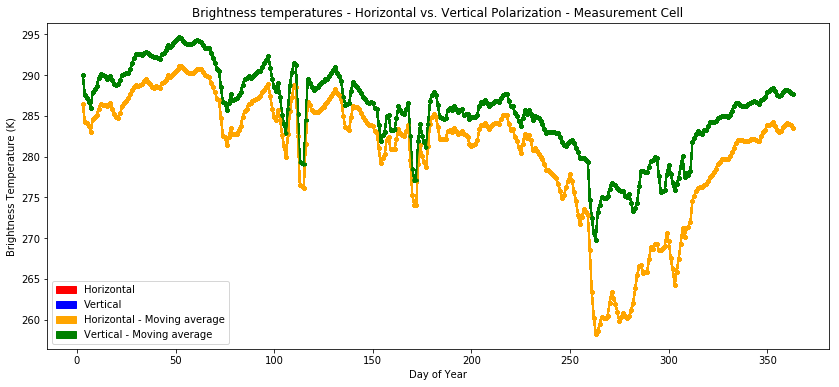

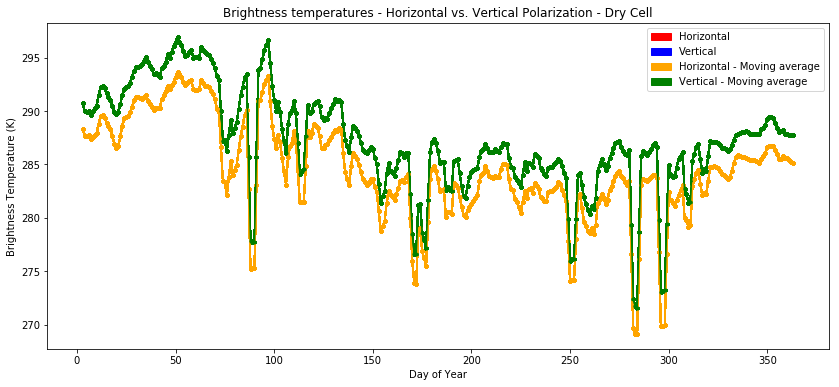

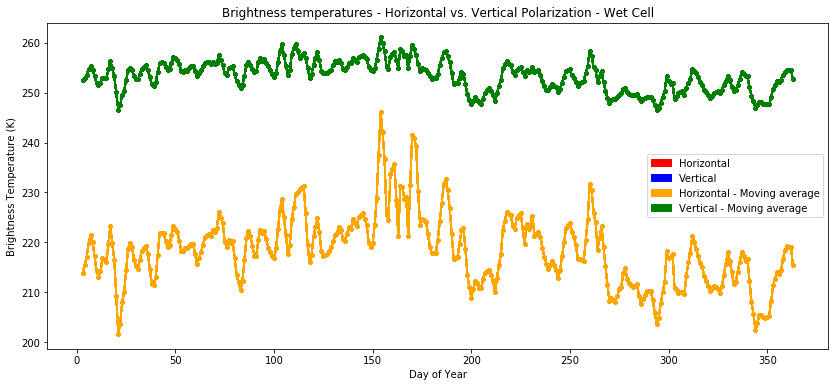

In [23]:
# PLOT HORIZONTAL VS. VERTICAL POLARIZATION

#----------MEASUREMENT CELL----------------------------------------------------------------------------------------
plt.figure(figsize=(14,6))

for n in range(len(TB_37ghz_25km_H_A_measurement)):
#     plt.plot(TB_37ghz_25km_H_A_measurement, marker='.', color='red')
#     plt.plot(TB_37ghz_25km_V_A_measurement, marker='.', color='blue')
    plt.plot(TB_37ghz_25km_H_A_measurement_ma, marker='.', color='orange')
    plt.plot(TB_37ghz_25km_V_A_measurement_ma, marker='.', color='green')
    
red_patch = mpatches.Patch(color='red', label='Horizontal')
blue_patch = mpatches.Patch(color='blue', label='Vertical')
orange_patch = mpatches.Patch(color='orange', label='Horizontal - Moving average')
green_patch = mpatches.Patch(color='green', label='Vertical - Moving average')

plt.legend(handles=[red_patch,blue_patch,orange_patch,green_patch])
plt.title('Brightness temperatures - Horizontal vs. Vertical Polarization - Measurement Cell')
plt.xlabel('Day of Year')
plt.ylabel('Brightness Temperature (K)')


#----------DRY CALIBRATION----------------------------------------------------------------------------------------
plt.figure(figsize=(14,6))
# values_37ghz_25km_H_A = ts_37ghz_25km_H_A['TB'].values
for n in range(len(TB_37ghz_25km_H_A_measurement)):
#     plt.plot(TB_37ghz_25km_H_A_dry, marker='.', color='red')#, label='37GHz, Ascending, Measurement cell'
#     plt.plot(TB_37ghz_25km_V_A_dry, marker='.', color='blue')
    plt.plot(TB_37ghz_25km_H_A_dry_ma, marker='.', color='orange')
    plt.plot(TB_37ghz_25km_V_A_dry_ma, marker='.', color='green')

red_patch = mpatches.Patch(color='red', label='Horizontal')
blue_patch = mpatches.Patch(color='blue', label='Vertical')
orange_patch = mpatches.Patch(color='orange', label='Horizontal - Moving average')
green_patch = mpatches.Patch(color='green', label='Vertical - Moving average')

plt.legend(handles=[red_patch,blue_patch,orange_patch,green_patch])
plt.title('Brightness temperatures - Horizontal vs. Vertical Polarization - Dry Cell')
plt.xlabel('Day of Year')
plt.ylabel('Brightness Temperature (K)')


#----------WET CALIBRATION----------------------------------------------------------------------------------------
plt.figure(figsize=(14,6))
# values_37ghz_25km_H_A = ts_37ghz_25km_H_A['TB'].values
for n in range(len(TB_37ghz_25km_H_A_measurement)):
#     plt.plot(TB_37ghz_25km_H_A_wet, marker='.', color='red')#, label='37GHz, Ascending, Measurement cell'
#     plt.plot(TB_37ghz_25km_V_A_wet, marker='.', color='blue')
    plt.plot(TB_37ghz_25km_H_A_wet_ma, marker='.', color='orange')
    plt.plot(TB_37ghz_25km_V_A_wet_ma, marker='.', color='green')

red_patch = mpatches.Patch(color='red', label='Horizontal')
blue_patch = mpatches.Patch(color='blue', label='Vertical')
orange_patch = mpatches.Patch(color='orange', label='Horizontal - Moving average')
green_patch = mpatches.Patch(color='green', label='Vertical - Moving average')

plt.legend(handles=[red_patch,blue_patch,orange_patch,green_patch])
plt.title('Brightness temperatures - Horizontal vs. Vertical Polarization - Wet Cell')
plt.xlabel('Day of Year')
plt.ylabel('Brightness Temperature (K)')

# 37 GHz vs. 89 GHz

Text(0,0.5,'Brightness Temperature (K)')

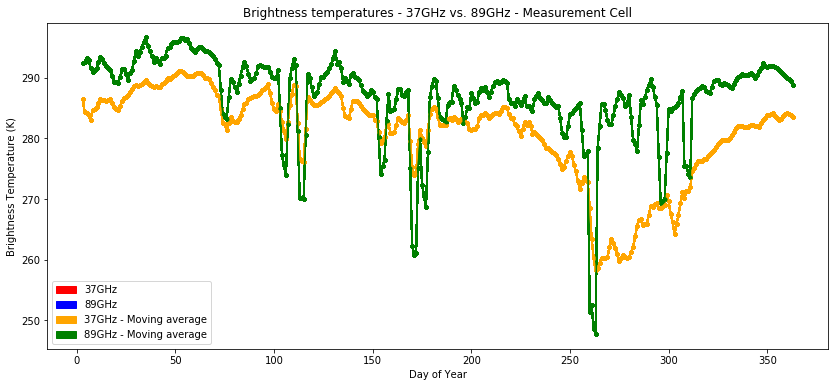

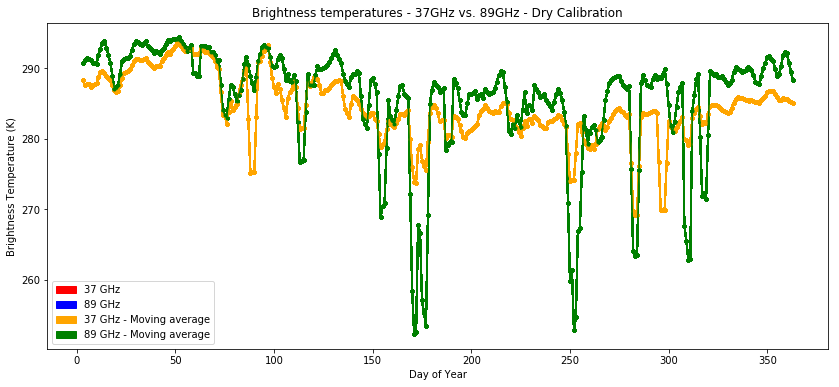

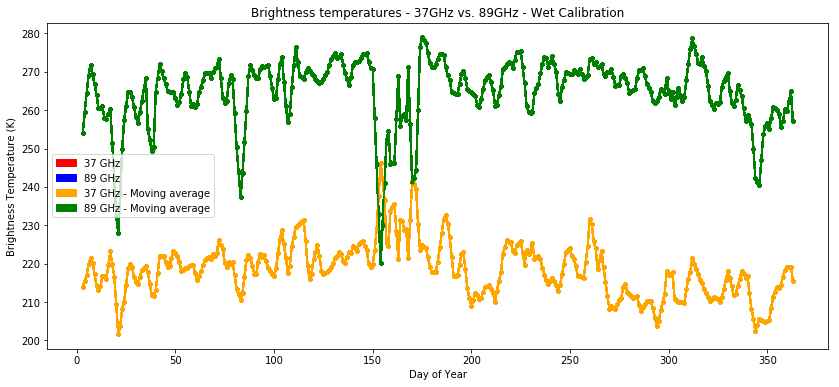

In [24]:
# PLOT 37GHz. vs. 89 GHz.


#----------MEASUREMENT CELL----------------------------------------------------------------------------------------
plt.figure(figsize=(14,6))
for n in range(len(TB_37ghz_25km_H_A_measurement)):
#     plt.plot(TB_37ghz_25km_H_A_measurement, marker='.', color='red')
#     plt.plot(TB_89ghz_3km_H_A_measurement, marker='.', color='blue')
    plt.plot(TB_37ghz_25km_H_A_measurement_ma, marker='.', color='orange')
    plt.plot(TB_89ghz_3km_H_A_measurement_ma, marker='.', color='green')
    
red_patch = mpatches.Patch(color='red', label='37GHz')
blue_patch = mpatches.Patch(color='blue', label='89GHz')
orange_patch = mpatches.Patch(color='orange', label='37GHz - Moving average')
green_patch = mpatches.Patch(color='green', label='89GHz - Moving average')

plt.legend(handles=[red_patch,blue_patch,orange_patch,green_patch])
plt.title('Brightness temperatures - 37GHz vs. 89GHz - Measurement Cell')
plt.xlabel('Day of Year')
plt.ylabel('Brightness Temperature (K)')


#----------DRY CALIBRATION----------------------------------------------------------------------------------------
plt.figure(figsize=(14,6))

# values_37ghz_25km_H_A = ts_37ghz_25km_H_A['TB'].values
for n in range(len(TB_37ghz_25km_H_A_measurement)):
#     plt.plot(TB_37ghz_25km_H_A_dry, marker='.', color='red')
#     plt.plot(TB_89ghz_3km_H_A_dry, marker='.', color='blue')
    plt.plot(TB_37ghz_25km_H_A_dry_ma, marker='.', color='orange')
    plt.plot(TB_89ghz_3km_H_A_dry_ma, marker='.', color='green')

red_patch = mpatches.Patch(color='red', label='37 GHz')
blue_patch = mpatches.Patch(color='blue', label='89 GHz')
orange_patch = mpatches.Patch(color='orange', label='37 GHz - Moving average')
green_patch = mpatches.Patch(color='green', label='89 GHz - Moving average')

plt.legend(handles=[red_patch,blue_patch,orange_patch,green_patch])
plt.title('Brightness temperatures - 37GHz vs. 89GHz - Dry Calibration')
plt.xlabel('Day of Year')
plt.ylabel('Brightness Temperature (K)')


#----------WET CALIBRATION----------------------------------------------------------------------------------------
plt.figure(figsize=(14,6))
for n in range(len(TB_37ghz_25km_H_A_measurement)):
#     plt.plot(TB_37ghz_25km_H_A_wet, marker='.', color='red')
#     plt.plot(TB_89ghz_3km_H_A_wet, marker='.', color='blue')
    plt.plot(TB_37ghz_25km_H_A_wet_ma, marker='.', color='orange')
    plt.plot(TB_89ghz_3km_H_A_wet_ma, marker='.', color='green')

red_patch = mpatches.Patch(color='red', label='37 GHz')
blue_patch = mpatches.Patch(color='blue', label='89 GHz')
orange_patch = mpatches.Patch(color='orange', label='37 GHz - Moving average')
green_patch = mpatches.Patch(color='green', label='89 GHz - Moving average')

plt.legend(handles=[red_patch,blue_patch,orange_patch,green_patch])
plt.title('Brightness temperatures - 37GHz vs. 89GHz - Wet Calibration')
plt.xlabel('Day of Year')
plt.ylabel('Brightness Temperature (K)')

# Load Discharge Data - Bonou 2010

# C-M Ratio

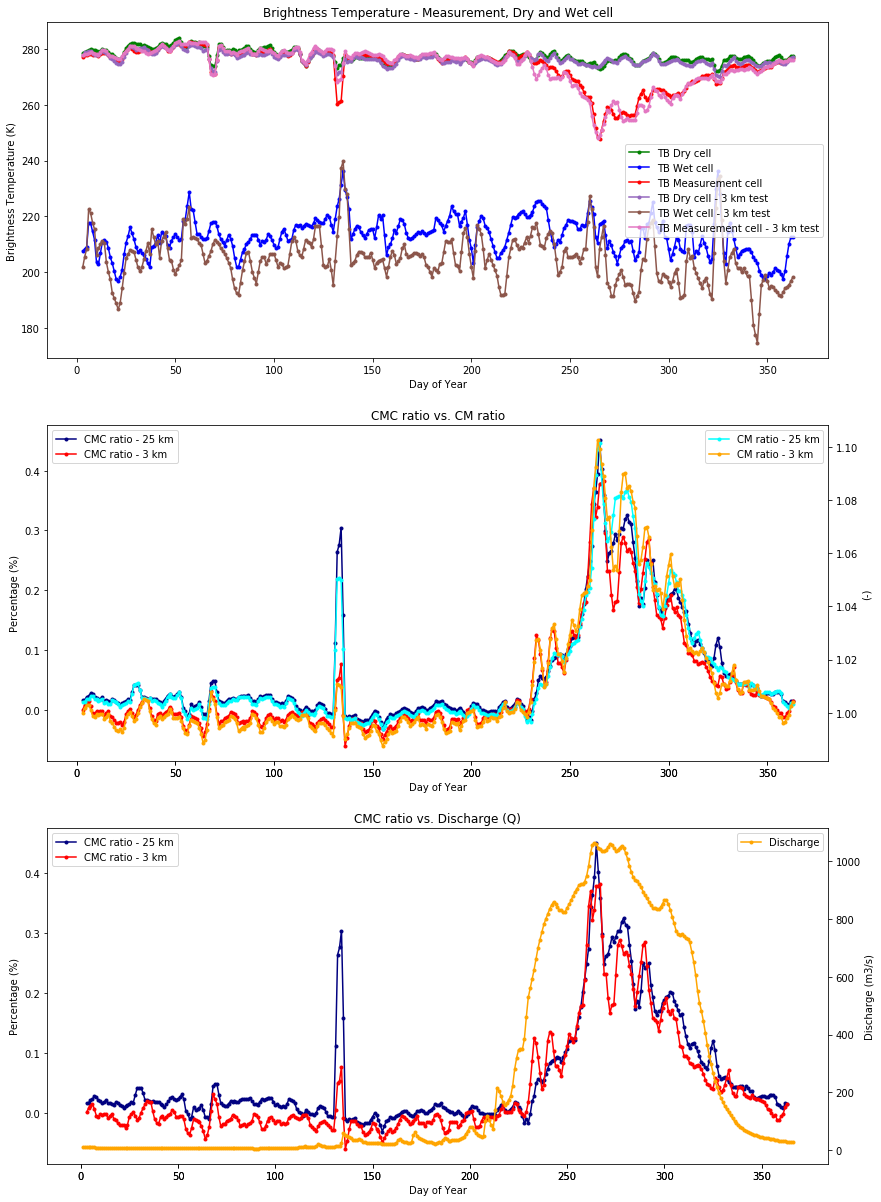

In [25]:
#CM & CMC Ratio
from pylab import figure, show, legend, ylabel, axes, pie, title
import matplotlib.patches as mpatches

#Define cells - BEST ESTIMATE
C_dry_be = TB_37ghz_25km_H_D_dry_ma #be = best estimate, to distinguish the cells from other (reference) CM(C) ratios
C_wet_be = TB_37ghz_25km_H_D_wet_ma
M_be = TB_37ghz_25km_H_D_measurement_ma
# Add cells to test
C_dry_test1 = TB_37ghz_3km_H_D_dry_ma #testing, especially with combinations of tile sizes for the stability of the signal
C_wet_test1 = TB_37ghz_3km_H_D_wet_ma
M_test1 = TB_37ghz_3km_H_D_measurement_ma

#CM(C) Ratio - BEST ESTIMATE
CM_be = (C_dry_be / M_be)
# CM_be[CM_be<0] = CM_be.fillna(method='ffill',inplace=True) #Discard values < 0
CMC_be = (C_dry_be - M_be)/(C_dry_be - C_wet_be)
# CMC_be[CMC_be<0] = CMC_be.fillna(method='ffill',inplace=True) #Discard values < 0
# CM(C) Ratio Test
CM_test1 = (C_dry_test1 / M_test1)
# CM_test1[CM_test1<0] = CM_test1.fillna(method='ffill',inplace=True) # Discard values < 0
CMC_test1 = (C_dry_test1 - M_test1)/(C_dry_test1 - C_wet_test1)
# CMC_test1[CMC_test1<0] = CMC_test1.fillna(method='ffill',inplace=True) # Discard values < 0

fig = plt.figure(figsize=(14,21))

#---------Plot the individual TB's-------------------------------------
ax1 = fig.add_subplot(311)
# Best estimate data
ax1.plot(C_dry_be, marker='.', color='g', label = 'TB Dry cell')
ax1.plot(C_wet_be, marker='.', color='b', label = 'TB Wet cell')
ax1.plot(M_be, marker='.', color='r', label = 'TB Measurement cell')
# Test data
ax1.plot(C_dry_test1, marker='.', color='C4', label = 'TB Dry cell - 3 km test')
ax1.plot(C_wet_test1, marker='.', color='C5', label = 'TB Wet cell - 3 km test')
ax1.plot(M_test1, marker='.', color='C6', label = 'TB Measurement cell - 3 km test')

ax1.legend()


plt.title('Brightness Temperature - Measurement, Dry and Wet cell')
plt.xlabel('Day of Year')
plt.ylabel('Brightness Temperature (K)')

#-------Plot the CM Ratio vs. CMC Ratio----------------------------------
ax2 = fig.add_subplot(312)
plt.title('CMC ratio vs. CM ratio')
plt.xlabel('Day of Year')
plt.ylabel('Percentage (%)')
ax2.plot(CMC_be,marker='.', color='navy', label = 'CMC ratio - 25 km')
ax2.plot(CMC_test1,marker='.', color='red', label = 'CMC ratio - 3 km')
ax2.legend(loc=2)

ax3 = fig.add_subplot(312, frameon = False)
ax3.yaxis.tick_right()
ax3.yaxis.set_label_position("right")
plt.ylabel('(-)')
ax3.plot(CM_be,marker='.', color='cyan', label = 'CM ratio - 25 km')
ax3.plot(CM_test1,marker='.', color='orange', label = 'CM ratio - 3 km')
ax3.legend()

# navy_patch = mpatches.Patch(color='navy', label='CM ratio')
# goldenrod_patch = mpatches.Patch(color='goldenrod', label='CMC ratio')
# plt.legend(handles=[navy_patch,goldenrod_patch])

# red_patch = mpatches.Patch(color='red', label='Discharge (m3/s)')
# blue_patch = mpatches.Patch(color='blue', label='C/M/C ratio (%)')
# # green_patch = mpatches.Patch(color='green', label='C/M ratio (-)')
# plt.legend(handles=[red_patch,blue_patch])
# plt.show()


#---------Plot Q vs. CMC Ratio------------------------------------
ax4 = fig.add_subplot(313)
plt.title('CMC ratio vs. Discharge (Q)')
plt.xlabel('Day of Year')
plt.ylabel('Percentage (%)')
ax4.plot(CMC_be,marker='.', color='navy', label = 'CMC ratio - 25 km')
ax4.plot(CMC_test1,marker='.', color='red', label = 'CMC ratio - 3 km')
ax4.legend(loc=2)

ax5 = fig.add_subplot(313, sharex=ax4, frameon=False)
q_dis = ax5.plot(doy,q_2010, linestyle='-', color='orange',marker='.', label = 'Discharge')
ax5.yaxis.tick_right()
ax5.yaxis.set_label_position("right")
ylabel("Discharge (m3/s)")
ax5.legend()


# Comparison of all possible CMC Ratio's


In [13]:
#CM & CMC Ratio
from pylab import figure, show, legend, ylabel, axes, pie, title
import matplotlib.patches as mpatches

#Define possible CMC ratios
CMC_37ghz_25km_H_A = (TB_37ghz_25km_H_A_dry_ma - TB_37ghz_25km_H_A_measurement_ma)/(TB_37ghz_25km_H_A_dry_ma - TB_37ghz_25km_H_A_wet_ma)
CMC_37ghz_25km_H_D = (TB_37ghz_25km_H_D_dry_ma - TB_37ghz_25km_H_D_measurement_ma)/(TB_37ghz_25km_H_D_dry_ma - TB_37ghz_25km_H_D_wet_ma)
CMC_37ghz_25km_V_A = (TB_37ghz_25km_V_A_dry_ma - TB_37ghz_25km_V_A_measurement_ma)/(TB_37ghz_25km_V_A_dry_ma - TB_37ghz_25km_V_A_wet_ma)
CMC_37ghz_25km_V_D = (TB_37ghz_25km_V_D_dry_ma - TB_37ghz_25km_V_D_measurement_ma)/(TB_37ghz_25km_V_D_dry_ma - TB_37ghz_25km_V_D_wet_ma)

#Define possible CM ratios
CM_37ghz_25km_H_A = (TB_37ghz_25km_H_A_dry_ma/TB_37ghz_25km_H_A_measurement_ma)
CM_37ghz_25km_H_D = (TB_37ghz_25km_H_D_dry_ma/TB_37ghz_25km_H_D_measurement_ma)
CM_37ghz_25km_V_A = (TB_37ghz_25km_V_A_dry_ma/TB_37ghz_25km_V_A_measurement_ma)
CM_37ghz_25km_V_D = (TB_37ghz_25km_V_D_dry_ma/TB_37ghz_25km_V_D_measurement_ma)

fig = plt.figure(figsize=(30,14))

#---------Plot the possible CMC ratio's---------------------------------------------------------------------
ax1 = fig.add_subplot(221)
ax1.plot(CMC_37ghz_25km_H_A, marker='.', color='C0', label = '37 GHz - 25 km - H - A')
ax1.plot(CMC_37ghz_25km_H_D, marker='.', color='C1', label = '37 GHz - 25 km - H - D')
ax1.plot(CMC_37ghz_25km_V_A, marker='.', color='C2', label = '37 GHz - 25 km - V - A')
ax1.plot(CMC_37ghz_25km_V_D, marker='.', color='C3', label = '37 GHz - 25 km - V - D')
ax1.legend()

plt.title('Comparison of possible CMC Ratios')
plt.xlabel('Day of Year')
plt.ylabel('Percentage (%)')

#---------Again plot all possible CMC ratio's---------------------------------------------------------------------
ax2 = fig.add_subplot(223)
plt.title('CMC ratios vs. Discharge (Q)')
plt.xlabel('Day of Year')
plt.ylabel('Percentage (%)')
ax2.plot(CMC_37ghz_25km_H_A, marker='.', color='C0', label = '37 GHz - 25 km - H - A')
ax2.plot(CMC_37ghz_25km_H_D, marker='.', color='C1', label = '37 GHz - 25 km - H - D')
ax2.plot(CMC_37ghz_25km_V_A, marker='.', color='C2', label = '37 GHz - 25 km - V - A')
ax2.plot(CMC_37ghz_25km_V_D, marker='.', color='C3', label = '37 GHz - 25 km - V - D')
ax2.legend(loc=2)

# Add the discharge data
ax3 = fig.add_subplot(223, sharex=ax2, frameon=False)
q_dis = ax3.plot(doy,q_2010, linestyle='-', color='C5',marker='.', label = 'Discharge')
ax3.yaxis.tick_right()
ax3.yaxis.set_label_position("right")
ylabel("Discharge (m3/s)")
ax3.legend()

#---------Plot all possible CM ratios---------------------------------------------------------------------
ax4 = fig.add_subplot(222)
ax4.plot(CM_37ghz_25km_H_A, marker='.', color='C0', label = '37 GHz - 25 km - H - A')
ax4.plot(CM_37ghz_25km_H_D, marker='.', color='C1', label = '37 GHz - 25 km - H - D')
ax4.plot(CM_37ghz_25km_V_A, marker='.', color='C2', label = '37 GHz - 25 km - V - A')
ax4.plot(CM_37ghz_25km_V_D, marker='.', color='C3', label = '37 GHz - 25 km - V - D')
ax4.legend()

plt.title('Comparison of possible CM Ratios')
plt.xlabel('Day of Year')
plt.ylabel('Ratio (-)')

#---------Again plot all possible CM ratios---------------------------------------------------------------------
ax5 = fig.add_subplot(224)
plt.title('CM ratios vs. Discharge (Q)')
plt.xlabel('Day of Year')
plt.ylabel('Ratio (-)')
ax5.plot(CM_37ghz_25km_H_A, marker='.', color='C0', label = '37 GHz - 25 km - H - A')
ax5.plot(CM_37ghz_25km_H_D, marker='.', color='C1', label = '37 GHz - 25 km - H - D')
ax5.plot(CM_37ghz_25km_V_A, marker='.', color='C2', label = '37 GHz - 25 km - V - A')
ax5.plot(CM_37ghz_25km_V_D, marker='.', color='C3', label = '37 GHz - 25 km - V - D')
ax5.legend(loc=2)

# Add the discharge data
ax6 = fig.add_subplot(224, sharex=ax5, frameon=False)
q_dis = ax6.plot(doy,q_2010, linestyle='-', color='C5',marker='.', label = 'Discharge')
ax6.yaxis.tick_right()
ax6.yaxis.set_label_position("right")
ylabel("Discharge (m3/s)")
ax6.legend()

NameError: name 'TB_37ghz_25km_H_A_dry_ma' is not defined

# Testing CM vs. CMC ratio

RMSE
The RMSE between CMC_be and CM_be is: 0.9581851656603305 ??
The RMSE between CMC_be and CMC_3km is: 0.036475027705817176 ??
The NRMSE between CMC_be and CM_be is: 1.9861930446888225 ??
Variance CMC is: 0.00843947313447086
Variance of CM is: 0.00048240254135977086
Covariance of CMC-CM is: 0.001996831904338403
The Pearson correlation coefficient of CMC_be-CM_be is: 0.9896441138857376
The Pearson correlation coefficient of CMC_3km-CM_3km is: 0.9999999999999999
The Pearson correlation coefficient of CMC_be-CMC_3km is: 0.9434110103387088
The Pearson correlation coefficient of CM_be-CM_3km is: 0.9407640751571418


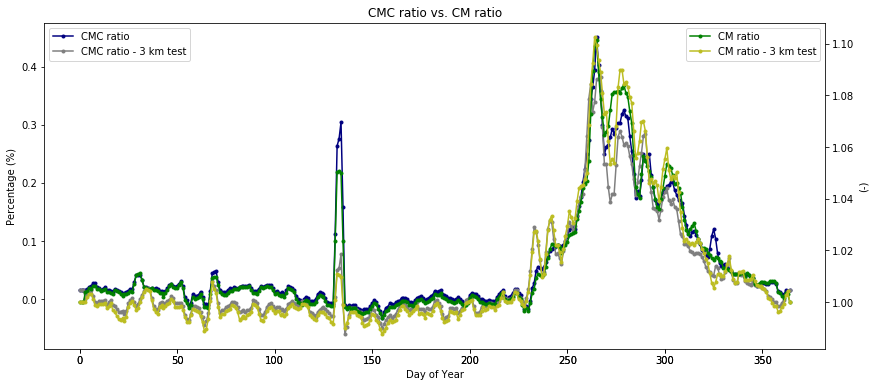

In [28]:
#CM & CMC Ratio
from pylab import figure, show, legend, ylabel, axes, pie, title
import matplotlib.patches as mpatches

#Define cells - BEST ESTIMATE
C_dry_be = TB_37ghz_25km_H_D_dry_ma #be = best estimate, to distinguish the cells from other (reference) CM(C) ratios
C_wet_be = TB_37ghz_25km_H_D_wet_ma
M_be = TB_37ghz_25km_H_D_measurement_ma
# Add cells to test
C_dry_test1 = TB_37ghz_3km_H_D_dry_ma #testing, especially with combinations of tile sizes for the stability of the signal
C_wet_test1 = TB_37ghz_3km_H_D_wet_ma
M_test1 = TB_37ghz_3km_H_D_measurement_ma

#CM(C) Ratio - BEST ESTIMATE
CM_be = (C_dry_be / M_be)
# CM_be[0:3] = 1
CM_be = CM_be.fillna(1)
# CM_be[CM_be<0] = CM_be.fillna(method='ffill',inplace=True) #Discard values < 0
CMC_be = (C_dry_be - M_be)/(C_dry_be - C_wet_be)
CMC_be = CMC_be.fillna(0.015)
# CMC_be[0:3] = 0.015
# CMC_be[CMC_be<0] = CMC_be.fillna(method='ffill',inplace=True) #Discard values < 0
# CM(C) Ratio Test
CM_test1 = (C_dry_test1 / M_test1)
CM_test1 = CM_test1.fillna(1)
# CM_test1[CM_test1<0] = CM_test1.fillna(method='ffill',inplace=True) # Discard values < 0
CMC_test1 = (C_dry_test1 - M_test1)/(C_dry_test1 - C_wet_test1)
CMC_test1 = CMC_test1.fillna(0.015)
# CMC_test1[CMC_test1<0] = CMC_test1.fillna(method='ffill',inplace=True) # Discard values < 0



fig = plt.figure(figsize=(14,6))
#-------Plot the CM Ratio vs. CMC Ratio----------------------------------
ax1=fig.add_subplot(111)
ax1.plot(CMC_be,marker='.', color='navy', label = 'CMC ratio')
ax1.plot(CMC_test1,marker='.', color='C7', label = 'CMC ratio - 3 km test')
# ax1.plot(CM_be,marker='.', color='g', label = 'CM ratio')
# ax1.plot(CM_test1,marker='.', color='C8', label = 'CM ratio - 3 km test')

plt.title('CMC ratio vs. CM ratio')
plt.xlabel('Day of Year')
plt.ylabel('Percentage (%)')
ax1.legend(loc=2)

ax2 = fig.add_subplot(111, frameon = False)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
plt.ylabel('(-)')
ax2.plot(CM_be,marker='.', color='g', label = 'CM ratio')
ax2.plot(CM_test1,marker='.', color='C8', label = 'CM ratio - 3 km test')
ax2.legend()

#

# def rmse_cmc_cm(CMC_be, CM_be):
#     return np.sqrt(((CMC_be - CM_be) ** 2).mean())
# rmse_cmc_cm = rmse_cmc_cm(CMC_be[0],CM_be[0])
# print('The RMSE between CMC_be and CM_be is:',rmse_cmc_cm)

# def rmse_cmc_cm(CMC_be, CMC_test1):
#     return np.sqrt(((CMC_be - CMC_test1) ** 2).mean())
# rmse_cmc_cmc = rmse_cmc_cm(CMC_be[0],CMC_test1[0])
# print('The RMSE between CMC_be and CMC_test1 is:',rmse_cmc_cmc)

# def rmse_cmc_cm(CM_be, CM_test1):
#     return np.sqrt(((CM_be - CM_test1) ** 2).mean())
# rmse_cm_cm = rmse_cmc_cm(CM_be[0],CM_test1[0])
# print('The RMSE between CM_be and CM_test1 is:',rmse_cm_cm)

# #NOTE: vreemd, CMC vs. CM lijkt een veel betere fit dan vergelijking van CMC vs. CMC of CM vs. CM..?

CMC = CMC_be
CM = CM_be
CMC_3km = CMC_test1
CM_3km = CMC_test1
#--------Testing CMC-CM------------------------------
print('RMSE')
def rmse(CMC, CM):
    return np.sqrt(((CMC - CM) ** 2).mean())
rmse_cmc_cm = rmse(CMC[0],CM[0])
print('The RMSE between CMC_be and CM_be is:',rmse_cmc_cm,'??')
rmse_cmc_cmc = rmse(CMC[0],CMC_3km[0])
print('The RMSE between CMC_be and CMC_3km is:',rmse_cmc_cmc,'??')


def nrmse(CMC, CM):
    return np.sqrt(((CMC - CM) ** 2).mean())/(CMC.max() - CMC.min())
nrmse = nrmse(CMC[0],CM[0])
print('The NRMSE between CMC_be and CM_be is:',nrmse,'??')

var_cmc = CMC[0].var()
print('Variance CMC is:',var_cmc)

var_cm = CM[0].var()
print('Variance of CM is:', var_cm)

cov_cmc_cm = np.cov(CMC[0],CM[0])
print('Covariance of CMC-CM is:',cov_cmc_cm.item(2))

corr_cmc_cm = np.corrcoef(CMC[0],CM[0])
print('The Pearson correlation coefficient of CMC_be-CM_be is:',corr_cmc_cm.item(2))
corr_cmc_cm_3km = np.corrcoef(CMC_3km[0],CM_3km[0])
print('The Pearson correlation coefficient of CMC_3km-CM_3km is:',corr_cmc_cm_3km.item(2))
corr_cmc_cmc = np.corrcoef(CMC[0],CMC_3km[0])
print('The Pearson correlation coefficient of CMC_be-CMC_3km is:',corr_cmc_cmc.item(2))
corr_cm_cm = np.corrcoef(CM[0],CM_3km[0])
print('The Pearson correlation coefficient of CM_be-CM_3km is:',corr_cm_cm.item(2))


In [29]:
# CMC[0]